In [1]:
import keras
from keras.models import Sequential
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [01:23<00:00, 156.23it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:41<00:00, 133.99it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(y_train.shape)
print(y_test.shape)
train.nunique()
val.nunique()

(13022,)
(5509,)


image    5509
class      51
dtype: int64

In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [10]:
# creating the base model of pre-trained VGG16 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 1536)


In [12]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
________________________________________________________________________________

__________________________________________________________________________________________________
mixed_5b (Concatenate)          (None, None, None, 3 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 3 10240       mixed_5b[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 3 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 3 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, None, 3 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_24 (Activation)      (None, None, None, 6 0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, None, None, 1 0           activation_19[0][0]              
                                                                 activation_21[0][0]              
                                                                 activation_24[0][0]              
__________

__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 3 10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, None, 3 9216        activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, None, None, 6 27648       activation_35[0][0]              
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, None, None, 3 96          conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, None, 3 96          conv2d_33[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 3 10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, None, None, 4 13824       activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 3 96          conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, None, None, 4 144         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, None, None, 3 0           batch_normalization_44[0][0]     
__________

block35_7_conv (Conv2D)         (None, None, None, 3 41280       block35_7_mixed[0][0]            
__________________________________________________________________________________________________
block35_7 (Lambda)              (None, None, None, 3 0           block35_6_ac[0][0]               
                                                                 block35_7_conv[0][0]             
__________________________________________________________________________________________________
block35_7_ac (Activation)       (None, None, None, 3 0           block35_7[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 3 10240       block35_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, None, None, 3 96          conv2d_58[0][0]                  
__________

batch_normalization_66 (BatchNo (None, None, None, 6 192         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, None, None, 3 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, None, None, 3 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_66 (Activation)      (None, None, None, 6 0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, None, None, 1 0           activation_61[0][0]              
                                                                 activation_63[0][0]              
          

batch_normalization_73 (BatchNo (None, None, None, 3 1152        conv2d_73[0][0]                  
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, None, None, 3 1152        conv2d_76[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, None, None, 3 0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
activation_76 (Activation)      (None, None, None, 3 0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 3 0           block35_10_ac[0][0]              
__________________________________________________________________________________________________
mixed_6a (

conv2d_86 (Conv2D)              (None, None, None, 1 139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, None, None, 1 384         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, None, None, 1 0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, None, None, 1 143360      activation_86[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, None, None, 1 480         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation

conv2d_96 (Conv2D)              (None, None, None, 1 215040      activation_95[0][0]              
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, None, None, 1 576         conv2d_93[0][0]                  
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, None, None, 1 576         conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 1 0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
activation_96 (Activation)      (None, None, None, 1 0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
block17_5_

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, None, None, 1 0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, None, None, 1 0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, None, None, 1 139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, None, None, 1 384         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation

batch_normalization_115 (BatchN (None, None, None, 1 480         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, None, None, 1 0           batch_normalization_115[0][0]    
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, None, None, 1 208896      block17_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, None, None, 1 215040      activation_115[0][0]             
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, None, None, 1 576         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_124 (Activation)     (None, None, None, 1 0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, None, None, 3 0           activation_121[0][0]             
                                                                 activation_124[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, None, None, 1 418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, None, None, 1 0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_134 (BatchN (None, None, None, 1 384         conv2d_134[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, None, None, 1 0           batch_normalization_134[0][0]    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, None, None, 1 143360      activation_134[0][0]             
__________________________________________________________________________________________________
batch_normalization_135 (BatchN (None, None, None, 1 480         conv2d_135[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, None, None, 1 0           batch_normalization_135[0][0]    
__________________________________________________________________________________________________
conv2d_133

batch_normalization_141 (BatchN (None, None, None, 1 576         conv2d_141[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, None, None, 1 576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_141 (Activation)     (None, None, None, 1 0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, None, None, 1 0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, None, None, 3 0           activation_141[0][0]             
                                                                 activation_144[0][0]             
__________

                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, None, None, 1 0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, None, None, 1 139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 384         conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_154 (Activation)     (None, None, None, 1 0           batch_normalization_154[0][0]    
__________________________________________________________________________________________________
conv2d_155

mixed_7a (Concatenate)          (None, None, None, 2 0           activation_158[0][0]             
                                                                 activation_160[0][0]             
                                                                 activation_163[0][0]             
                                                                 max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, None, None, 1 399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, None, None, 1 576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, None, None, 1 0           batch_normalization_165[0][0]    
__________

__________________________________________________________________________________________________
activation_174 (Activation)     (None, None, None, 2 0           batch_normalization_174[0][0]    
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, None, None, 1 399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, None, None, 2 172032      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, None, None, 1 576         conv2d_172[0][0]                 
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, None, None, 2 768         conv2d_175[0][0]                 
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, None, None, 4 0           activation_180[0][0]             
                                                                 activation_183[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, None, None, 2 933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, None, None, 2 0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, None, None, 2 0           block8_5[0][0]                   
__________

__________________________________________________________________________________________________
activation_193 (Activation)     (None, None, None, 1 0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, None, None, 2 129024      activation_193[0][0]             
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, None, None, 2 672         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_194 (Activation)     (None, None, None, 2 0           batch_normalization_194[0][0]    
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, None, None, 1 399360      block8_7_ac[0][0]                
__________

__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, None, None, 2 768         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, None, None, 1 0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
activation_203 (Activation)     (None, None, None, 2 0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, None, None, 4 0           activation_200[0][0]             
                                                                 activation_203[0][0]             
__________________________________________________________________________________________________
block8_10_

In [13]:
base_model.get_config()

{'name': 'inception_resnet_v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[[

In [14]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(13022, 5, 5, 1536)

In [15]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(5509, 5, 5, 1536)

In [16]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 5*5*1536)
X_test = X_test.reshape(5509, 5*5*1536)

In [17]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [18]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/InceptionResNetV2_X_train.pkl') 
joblib.dump(X_test, '../Pickle/InceptionResNetV2_X_test.pkl')

['../Pickle/InceptionResNetV2_X_test.pkl']

In [19]:
# Load the model from the file 
X_train = joblib.load('../Pickle/InceptionResNetV2_X_train.pkl') 
X_test = joblib.load('../Pickle/InceptionResNetV2_X_test.pkl') 

In [20]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 38400)
(5509, 38400)
(13022, 51)
(5509, 51)


In [21]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(38400,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [22]:
model.output_shape

(None, 51)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              39322624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [24]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 38400),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [25]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightInceptionResNetV2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [26]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [27]:
# training the model
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 4:32 - loss: 3.9442 - accuracy: 0.00 - ETA: 2:50 - loss: 4.0095 - accuracy: 0.00 - ETA: 2:16 - loss: 4.0621 - accuracy: 0.01 - ETA: 1:58 - loss: 4.1850 - accuracy: 0.01 - ETA: 1:47 - loss: 4.2108 - accuracy: 0.01 - ETA: 1:39 - loss: 4.1798 - accuracy: 0.01 - ETA: 1:33 - loss: 4.1997 - accuracy: 0.01 - ETA: 1:30 - loss: 4.1799 - accuracy: 0.01 - ETA: 1:27 - loss: 4.1549 - accuracy: 0.02 - ETA: 1:23 - loss: 4.1392 - accuracy: 0.01 - ETA: 1:21 - loss: 4.1287 - accuracy: 0.01 - ETA: 1:19 - loss: 4.1197 - accuracy: 0.02 - ETA: 1:16 - loss: 4.1138 - accuracy: 0.01 - ETA: 1:14 - loss: 4.1131 - accuracy: 0.01 - ETA: 1:13 - loss: 4.1060 - accuracy: 0.01 - ETA: 1:11 - loss: 4.1049 - accuracy: 0.02 - ETA: 1:10 - loss: 4.1007 - accuracy: 0.02 - ETA: 1:08 - loss: 4.0895 - accuracy: 0.02 - ETA: 1:07 - loss: 4.0856 - accuracy: 0.02 - ETA: 1:05 - loss: 4.0821 - accuracy: 0.02 - ETA: 1:04 - 

13022/13022 [==============================] - ETA: 1:08 - loss: 3.6958 - accuracy: 0.08 - ETA: 1:06 - loss: 3.6793 - accuracy: 0.09 - ETA: 1:08 - loss: 3.6480 - accuracy: 0.09 - ETA: 1:08 - loss: 3.6574 - accuracy: 0.08 - ETA: 1:07 - loss: 3.6813 - accuracy: 0.08 - ETA: 1:06 - loss: 3.6545 - accuracy: 0.09 - ETA: 1:06 - loss: 3.6587 - accuracy: 0.09 - ETA: 1:05 - loss: 3.6404 - accuracy: 0.09 - ETA: 1:04 - loss: 3.6386 - accuracy: 0.09 - ETA: 1:03 - loss: 3.6238 - accuracy: 0.10 - ETA: 1:03 - loss: 3.6170 - accuracy: 0.10 - ETA: 1:02 - loss: 3.6057 - accuracy: 0.10 - ETA: 1:01 - loss: 3.5969 - accuracy: 0.10 - ETA: 1:00 - loss: 3.6030 - accuracy: 0.10 - ETA: 59s - loss: 3.5988 - accuracy: 0.1052 - ETA: 59s - loss: 3.5916 - accuracy: 0.106 - ETA: 58s - loss: 3.5953 - accuracy: 0.106 - ETA: 57s - loss: 3.5886 - accuracy: 0.107 - ETA: 57s - loss: 3.6003 - accuracy: 0.106 - ETA: 56s - loss: 3.5959 - accuracy: 0.105 - ETA: 55s - loss: 3.5878 - accuracy: 0.108 - ETA: 55s - loss: 3.5885 - ac

13022/13022 [==============================] - ETA: 1:05 - loss: 2.9434 - accuracy: 0.24 - ETA: 1:07 - loss: 3.0554 - accuracy: 0.20 - ETA: 1:09 - loss: 3.0508 - accuracy: 0.20 - ETA: 1:08 - loss: 3.0380 - accuracy: 0.20 - ETA: 1:08 - loss: 3.0453 - accuracy: 0.20 - ETA: 1:07 - loss: 3.0403 - accuracy: 0.20 - ETA: 1:06 - loss: 3.0302 - accuracy: 0.21 - ETA: 1:05 - loss: 3.0243 - accuracy: 0.21 - ETA: 1:04 - loss: 3.0288 - accuracy: 0.21 - ETA: 1:04 - loss: 3.0402 - accuracy: 0.21 - ETA: 1:03 - loss: 3.0633 - accuracy: 0.21 - ETA: 1:02 - loss: 3.0644 - accuracy: 0.21 - ETA: 1:01 - loss: 3.0642 - accuracy: 0.21 - ETA: 1:01 - loss: 3.0703 - accuracy: 0.21 - ETA: 1:00 - loss: 3.0504 - accuracy: 0.21 - ETA: 59s - loss: 3.0497 - accuracy: 0.2168 - ETA: 58s - loss: 3.0425 - accuracy: 0.220 - ETA: 58s - loss: 3.0532 - accuracy: 0.219 - ETA: 57s - loss: 3.0528 - accuracy: 0.217 - ETA: 56s - loss: 3.0433 - accuracy: 0.219 - ETA: 56s - loss: 3.0463 - accuracy: 0.219 - ETA: 55s - loss: 3.0501 - ac

13022/13022 [==============================] - ETA: 1:06 - loss: 2.8821 - accuracy: 0.21 - ETA: 1:06 - loss: 2.8571 - accuracy: 0.23 - ETA: 1:05 - loss: 2.7920 - accuracy: 0.26 - ETA: 1:05 - loss: 2.7648 - accuracy: 0.27 - ETA: 1:05 - loss: 2.7563 - accuracy: 0.27 - ETA: 1:04 - loss: 2.7392 - accuracy: 0.27 - ETA: 1:04 - loss: 2.7520 - accuracy: 0.27 - ETA: 1:03 - loss: 2.7319 - accuracy: 0.28 - ETA: 1:03 - loss: 2.7265 - accuracy: 0.28 - ETA: 1:02 - loss: 2.7429 - accuracy: 0.27 - ETA: 1:01 - loss: 2.7314 - accuracy: 0.28 - ETA: 1:01 - loss: 2.7366 - accuracy: 0.27 - ETA: 1:00 - loss: 2.7253 - accuracy: 0.27 - ETA: 59s - loss: 2.7220 - accuracy: 0.2835 - ETA: 59s - loss: 2.7086 - accuracy: 0.282 - ETA: 59s - loss: 2.6950 - accuracy: 0.284 - ETA: 58s - loss: 2.6890 - accuracy: 0.286 - ETA: 58s - loss: 2.6771 - accuracy: 0.287 - ETA: 57s - loss: 2.6640 - accuracy: 0.291 - ETA: 57s - loss: 2.6603 - accuracy: 0.289 - ETA: 56s - loss: 2.6570 - accuracy: 0.291 - ETA: 55s - loss: 2.6606 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 2.4270 - accuracy: 0.32 - ETA: 1:12 - loss: 2.4841 - accuracy: 0.31 - ETA: 1:11 - loss: 2.4195 - accuracy: 0.34 - ETA: 1:12 - loss: 2.4157 - accuracy: 0.35 - ETA: 1:11 - loss: 2.4347 - accuracy: 0.33 - ETA: 1:10 - loss: 2.4259 - accuracy: 0.35 - ETA: 1:09 - loss: 2.3882 - accuracy: 0.35 - ETA: 1:08 - loss: 2.3690 - accuracy: 0.36 - ETA: 1:07 - loss: 2.3872 - accuracy: 0.35 - ETA: 1:06 - loss: 2.3853 - accuracy: 0.35 - ETA: 1:05 - loss: 2.3665 - accuracy: 0.35 - ETA: 1:03 - loss: 2.3524 - accuracy: 0.36 - ETA: 1:03 - loss: 2.3607 - accuracy: 0.36 - ETA: 1:02 - loss: 2.3531 - accuracy: 0.36 - ETA: 1:01 - loss: 2.3690 - accuracy: 0.36 - ETA: 1:01 - loss: 2.3773 - accuracy: 0.36 - ETA: 1:00 - loss: 2.3614 - accuracy: 0.36 - ETA: 59s - loss: 2.3602 - accuracy: 0.3633 - ETA: 58s - loss: 2.3474 - accuracy: 0.366 - ETA: 57s - loss: 2.3435 - accuracy: 0.365 - ETA: 56s - loss: 2.3452 - accuracy: 0.363 - ETA: 56s - loss: 2.3438 - ac

13022/13022 [==============================] - ETA: 1:06 - loss: 2.2391 - accuracy: 0.37 - ETA: 1:09 - loss: 2.2324 - accuracy: 0.40 - ETA: 1:07 - loss: 2.2752 - accuracy: 0.41 - ETA: 1:09 - loss: 2.2259 - accuracy: 0.41 - ETA: 1:09 - loss: 2.2169 - accuracy: 0.40 - ETA: 1:08 - loss: 2.1702 - accuracy: 0.40 - ETA: 1:07 - loss: 2.1651 - accuracy: 0.41 - ETA: 1:06 - loss: 2.1924 - accuracy: 0.40 - ETA: 1:05 - loss: 2.1911 - accuracy: 0.40 - ETA: 1:04 - loss: 2.1885 - accuracy: 0.39 - ETA: 1:04 - loss: 2.2001 - accuracy: 0.39 - ETA: 1:03 - loss: 2.1978 - accuracy: 0.39 - ETA: 1:02 - loss: 2.1859 - accuracy: 0.39 - ETA: 1:01 - loss: 2.1991 - accuracy: 0.39 - ETA: 1:00 - loss: 2.1879 - accuracy: 0.39 - ETA: 59s - loss: 2.1825 - accuracy: 0.4004 - ETA: 59s - loss: 2.1732 - accuracy: 0.404 - ETA: 58s - loss: 2.1714 - accuracy: 0.406 - ETA: 57s - loss: 2.1629 - accuracy: 0.407 - ETA: 56s - loss: 2.1598 - accuracy: 0.408 - ETA: 56s - loss: 2.1578 - accuracy: 0.410 - ETA: 55s - loss: 2.1558 - ac

13022/13022 [==============================] - ETA: 1:07 - loss: 1.9935 - accuracy: 0.41 - ETA: 1:08 - loss: 1.8757 - accuracy: 0.45 - ETA: 1:08 - loss: 1.8347 - accuracy: 0.45 - ETA: 1:07 - loss: 1.7893 - accuracy: 0.46 - ETA: 1:06 - loss: 1.7996 - accuracy: 0.46 - ETA: 1:05 - loss: 1.8154 - accuracy: 0.45 - ETA: 1:04 - loss: 1.8292 - accuracy: 0.44 - ETA: 1:03 - loss: 1.8927 - accuracy: 0.43 - ETA: 1:02 - loss: 1.9351 - accuracy: 0.43 - ETA: 1:03 - loss: 1.9371 - accuracy: 0.43 - ETA: 1:02 - loss: 1.9326 - accuracy: 0.43 - ETA: 1:01 - loss: 1.9469 - accuracy: 0.42 - ETA: 1:00 - loss: 1.9554 - accuracy: 0.42 - ETA: 1:00 - loss: 1.9341 - accuracy: 0.43 - ETA: 59s - loss: 1.9422 - accuracy: 0.4318 - ETA: 58s - loss: 1.9391 - accuracy: 0.429 - ETA: 58s - loss: 1.9377 - accuracy: 0.433 - ETA: 57s - loss: 1.9384 - accuracy: 0.437 - ETA: 57s - loss: 1.9315 - accuracy: 0.439 - ETA: 56s - loss: 1.9200 - accuracy: 0.443 - ETA: 55s - loss: 1.9180 - accuracy: 0.444 - ETA: 55s - loss: 1.9188 - ac

13022/13022 [==============================] - ETA: 1:08 - loss: 1.6953 - accuracy: 0.51 - ETA: 1:06 - loss: 1.6846 - accuracy: 0.53 - ETA: 1:06 - loss: 1.6973 - accuracy: 0.51 - ETA: 1:06 - loss: 1.6674 - accuracy: 0.52 - ETA: 1:05 - loss: 1.6979 - accuracy: 0.51 - ETA: 1:05 - loss: 1.7545 - accuracy: 0.49 - ETA: 1:05 - loss: 1.7258 - accuracy: 0.50 - ETA: 1:05 - loss: 1.7372 - accuracy: 0.50 - ETA: 1:04 - loss: 1.7406 - accuracy: 0.50 - ETA: 1:04 - loss: 1.7407 - accuracy: 0.50 - ETA: 1:04 - loss: 1.7569 - accuracy: 0.49 - ETA: 1:03 - loss: 1.7635 - accuracy: 0.49 - ETA: 1:02 - loss: 1.7647 - accuracy: 0.49 - ETA: 1:02 - loss: 1.7583 - accuracy: 0.49 - ETA: 1:01 - loss: 1.7612 - accuracy: 0.48 - ETA: 1:00 - loss: 1.7653 - accuracy: 0.48 - ETA: 59s - loss: 1.7645 - accuracy: 0.4903 - ETA: 58s - loss: 1.7645 - accuracy: 0.489 - ETA: 58s - loss: 1.7740 - accuracy: 0.488 - ETA: 57s - loss: 1.7773 - accuracy: 0.487 - ETA: 56s - loss: 1.7767 - accuracy: 0.487 - ETA: 55s - loss: 1.7851 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 1.6954 - accuracy: 0.57 - ETA: 1:12 - loss: 1.7009 - accuracy: 0.54 - ETA: 1:11 - loss: 1.6990 - accuracy: 0.54 - ETA: 1:09 - loss: 1.7279 - accuracy: 0.52 - ETA: 1:08 - loss: 1.7692 - accuracy: 0.51 - ETA: 1:07 - loss: 1.7710 - accuracy: 0.51 - ETA: 1:06 - loss: 1.7779 - accuracy: 0.51 - ETA: 1:06 - loss: 1.7556 - accuracy: 0.51 - ETA: 1:05 - loss: 1.7491 - accuracy: 0.51 - ETA: 1:05 - loss: 1.7336 - accuracy: 0.51 - ETA: 1:04 - loss: 1.7258 - accuracy: 0.51 - ETA: 1:03 - loss: 1.7214 - accuracy: 0.51 - ETA: 1:03 - loss: 1.7106 - accuracy: 0.51 - ETA: 1:02 - loss: 1.7056 - accuracy: 0.51 - ETA: 1:01 - loss: 1.6939 - accuracy: 0.51 - ETA: 1:00 - loss: 1.6960 - accuracy: 0.51 - ETA: 59s - loss: 1.7018 - accuracy: 0.5161 - ETA: 58s - loss: 1.7018 - accuracy: 0.517 - ETA: 58s - loss: 1.6992 - accuracy: 0.519 - ETA: 57s - loss: 1.6964 - accuracy: 0.521 - ETA: 56s - loss: 1.7044 - accuracy: 0.519 - ETA: 55s - loss: 1.7018 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 1.7322 - accuracy: 0.55 - ETA: 1:12 - loss: 1.7073 - accuracy: 0.51 - ETA: 1:11 - loss: 1.6496 - accuracy: 0.52 - ETA: 1:10 - loss: 1.6113 - accuracy: 0.53 - ETA: 1:09 - loss: 1.6573 - accuracy: 0.52 - ETA: 1:07 - loss: 1.6835 - accuracy: 0.52 - ETA: 1:06 - loss: 1.6560 - accuracy: 0.52 - ETA: 1:05 - loss: 1.6628 - accuracy: 0.52 - ETA: 1:04 - loss: 1.6638 - accuracy: 0.52 - ETA: 1:03 - loss: 1.6488 - accuracy: 0.53 - ETA: 1:02 - loss: 1.6372 - accuracy: 0.53 - ETA: 1:02 - loss: 1.6098 - accuracy: 0.54 - ETA: 1:01 - loss: 1.6106 - accuracy: 0.53 - ETA: 1:00 - loss: 1.5985 - accuracy: 0.53 - ETA: 59s - loss: 1.5825 - accuracy: 0.5396 - ETA: 59s - loss: 1.5875 - accuracy: 0.542 - ETA: 58s - loss: 1.5743 - accuracy: 0.542 - ETA: 58s - loss: 1.5942 - accuracy: 0.536 - ETA: 57s - loss: 1.5975 - accuracy: 0.537 - ETA: 56s - loss: 1.5906 - accuracy: 0.540 - ETA: 56s - loss: 1.5858 - accuracy: 0.538 - ETA: 55s - loss: 1.5760 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 1.5284 - accuracy: 0.54 - ETA: 1:08 - loss: 1.5889 - accuracy: 0.51 - ETA: 1:08 - loss: 1.4968 - accuracy: 0.55 - ETA: 1:06 - loss: 1.4808 - accuracy: 0.56 - ETA: 1:05 - loss: 1.4535 - accuracy: 0.56 - ETA: 1:05 - loss: 1.4625 - accuracy: 0.55 - ETA: 1:05 - loss: 1.4123 - accuracy: 0.57 - ETA: 1:04 - loss: 1.4271 - accuracy: 0.57 - ETA: 1:04 - loss: 1.4381 - accuracy: 0.57 - ETA: 1:03 - loss: 1.4426 - accuracy: 0.57 - ETA: 1:03 - loss: 1.4334 - accuracy: 0.57 - ETA: 1:02 - loss: 1.4354 - accuracy: 0.58 - ETA: 1:02 - loss: 1.4494 - accuracy: 0.57 - ETA: 1:01 - loss: 1.4408 - accuracy: 0.57 - ETA: 1:01 - loss: 1.4368 - accuracy: 0.58 - ETA: 1:01 - loss: 1.4509 - accuracy: 0.57 - ETA: 1:00 - loss: 1.4363 - accuracy: 0.57 - ETA: 1:00 - loss: 1.4373 - accuracy: 0.57 - ETA: 59s - loss: 1.4310 - accuracy: 0.5777 - ETA: 58s - loss: 1.4383 - accuracy: 0.574 - ETA: 58s - loss: 1.4405 - accuracy: 0.575 - ETA: 57s - loss: 1.4352 - ac

13022/13022 [==============================] - ETA: 1:09 - loss: 1.5695 - accuracy: 0.53 - ETA: 1:08 - loss: 1.4868 - accuracy: 0.55 - ETA: 1:07 - loss: 1.5325 - accuracy: 0.53 - ETA: 1:08 - loss: 1.4881 - accuracy: 0.54 - ETA: 1:08 - loss: 1.4679 - accuracy: 0.55 - ETA: 1:06 - loss: 1.4272 - accuracy: 0.57 - ETA: 1:06 - loss: 1.4087 - accuracy: 0.57 - ETA: 1:05 - loss: 1.3921 - accuracy: 0.58 - ETA: 1:04 - loss: 1.3834 - accuracy: 0.58 - ETA: 1:03 - loss: 1.3728 - accuracy: 0.58 - ETA: 1:02 - loss: 1.3454 - accuracy: 0.59 - ETA: 1:01 - loss: 1.3566 - accuracy: 0.58 - ETA: 1:01 - loss: 1.3752 - accuracy: 0.57 - ETA: 1:00 - loss: 1.3896 - accuracy: 0.57 - ETA: 1:00 - loss: 1.4017 - accuracy: 0.57 - ETA: 59s - loss: 1.3983 - accuracy: 0.5732 - ETA: 58s - loss: 1.3996 - accuracy: 0.574 - ETA: 57s - loss: 1.3886 - accuracy: 0.577 - ETA: 56s - loss: 1.3942 - accuracy: 0.576 - ETA: 56s - loss: 1.3840 - accuracy: 0.580 - ETA: 55s - loss: 1.3861 - accuracy: 0.580 - ETA: 54s - loss: 1.3879 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 1.3402 - accuracy: 0.61 - ETA: 1:09 - loss: 1.3440 - accuracy: 0.59 - ETA: 1:08 - loss: 1.3516 - accuracy: 0.59 - ETA: 1:07 - loss: 1.3119 - accuracy: 0.60 - ETA: 1:06 - loss: 1.3236 - accuracy: 0.60 - ETA: 1:05 - loss: 1.3033 - accuracy: 0.60 - ETA: 1:05 - loss: 1.2797 - accuracy: 0.61 - ETA: 1:04 - loss: 1.2812 - accuracy: 0.61 - ETA: 1:03 - loss: 1.2712 - accuracy: 0.61 - ETA: 1:02 - loss: 1.2948 - accuracy: 0.61 - ETA: 1:02 - loss: 1.3255 - accuracy: 0.60 - ETA: 1:01 - loss: 1.3285 - accuracy: 0.60 - ETA: 1:00 - loss: 1.3257 - accuracy: 0.60 - ETA: 1:00 - loss: 1.3290 - accuracy: 0.60 - ETA: 59s - loss: 1.3464 - accuracy: 0.5995 - ETA: 58s - loss: 1.3522 - accuracy: 0.597 - ETA: 57s - loss: 1.3540 - accuracy: 0.595 - ETA: 57s - loss: 1.3578 - accuracy: 0.593 - ETA: 56s - loss: 1.3434 - accuracy: 0.597 - ETA: 55s - loss: 1.3520 - accuracy: 0.594 - ETA: 55s - loss: 1.3385 - accuracy: 0.597 - ETA: 54s - loss: 1.3476 - ac

13022/13022 [==============================] - ETA: 1:09 - loss: 1.2473 - accuracy: 0.60 - ETA: 1:09 - loss: 1.2100 - accuracy: 0.60 - ETA: 1:09 - loss: 1.2286 - accuracy: 0.59 - ETA: 1:07 - loss: 1.2630 - accuracy: 0.60 - ETA: 1:06 - loss: 1.2232 - accuracy: 0.61 - ETA: 1:05 - loss: 1.2386 - accuracy: 0.61 - ETA: 1:05 - loss: 1.2572 - accuracy: 0.61 - ETA: 1:04 - loss: 1.2368 - accuracy: 0.62 - ETA: 1:04 - loss: 1.2157 - accuracy: 0.62 - ETA: 1:03 - loss: 1.2438 - accuracy: 0.62 - ETA: 1:02 - loss: 1.2367 - accuracy: 0.62 - ETA: 1:02 - loss: 1.2333 - accuracy: 0.62 - ETA: 1:01 - loss: 1.2387 - accuracy: 0.61 - ETA: 1:00 - loss: 1.2535 - accuracy: 0.61 - ETA: 1:00 - loss: 1.2494 - accuracy: 0.61 - ETA: 59s - loss: 1.2576 - accuracy: 0.6152 - ETA: 59s - loss: 1.2550 - accuracy: 0.615 - ETA: 58s - loss: 1.2550 - accuracy: 0.615 - ETA: 58s - loss: 1.2526 - accuracy: 0.616 - ETA: 57s - loss: 1.2508 - accuracy: 0.619 - ETA: 56s - loss: 1.2632 - accuracy: 0.617 - ETA: 56s - loss: 1.2679 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.9969 - accuracy: 0.67 - ETA: 1:12 - loss: 1.1177 - accuracy: 0.65 - ETA: 1:11 - loss: 1.1861 - accuracy: 0.63 - ETA: 1:10 - loss: 1.2106 - accuracy: 0.62 - ETA: 1:08 - loss: 1.2325 - accuracy: 0.61 - ETA: 1:07 - loss: 1.2493 - accuracy: 0.61 - ETA: 1:06 - loss: 1.2227 - accuracy: 0.63 - ETA: 1:05 - loss: 1.1946 - accuracy: 0.63 - ETA: 1:04 - loss: 1.1917 - accuracy: 0.63 - ETA: 1:03 - loss: 1.1907 - accuracy: 0.63 - ETA: 1:02 - loss: 1.2233 - accuracy: 0.63 - ETA: 1:01 - loss: 1.2254 - accuracy: 0.63 - ETA: 1:01 - loss: 1.2254 - accuracy: 0.63 - ETA: 1:00 - loss: 1.2231 - accuracy: 0.63 - ETA: 59s - loss: 1.2272 - accuracy: 0.6292 - ETA: 59s - loss: 1.2200 - accuracy: 0.629 - ETA: 58s - loss: 1.2259 - accuracy: 0.626 - ETA: 57s - loss: 1.2236 - accuracy: 0.628 - ETA: 57s - loss: 1.2251 - accuracy: 0.630 - ETA: 56s - loss: 1.2183 - accuracy: 0.630 - ETA: 55s - loss: 1.2168 - accuracy: 0.630 - ETA: 55s - loss: 1.2133 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 1.1804 - accuracy: 0.67 - ETA: 1:10 - loss: 1.2273 - accuracy: 0.65 - ETA: 1:08 - loss: 1.2329 - accuracy: 0.64 - ETA: 1:07 - loss: 1.2157 - accuracy: 0.64 - ETA: 1:06 - loss: 1.1723 - accuracy: 0.65 - ETA: 1:05 - loss: 1.2052 - accuracy: 0.64 - ETA: 1:05 - loss: 1.2062 - accuracy: 0.64 - ETA: 1:04 - loss: 1.2233 - accuracy: 0.63 - ETA: 1:04 - loss: 1.2122 - accuracy: 0.64 - ETA: 1:03 - loss: 1.2039 - accuracy: 0.64 - ETA: 1:03 - loss: 1.2153 - accuracy: 0.63 - ETA: 1:02 - loss: 1.2022 - accuracy: 0.64 - ETA: 1:02 - loss: 1.2098 - accuracy: 0.64 - ETA: 1:01 - loss: 1.2063 - accuracy: 0.64 - ETA: 1:00 - loss: 1.1899 - accuracy: 0.64 - ETA: 59s - loss: 1.1959 - accuracy: 0.6421 - ETA: 59s - loss: 1.2140 - accuracy: 0.636 - ETA: 58s - loss: 1.2134 - accuracy: 0.636 - ETA: 58s - loss: 1.2213 - accuracy: 0.632 - ETA: 57s - loss: 1.2177 - accuracy: 0.628 - ETA: 56s - loss: 1.2150 - accuracy: 0.633 - ETA: 55s - loss: 1.2178 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.9982 - accuracy: 0.68 - ETA: 1:10 - loss: 1.2029 - accuracy: 0.63 - ETA: 1:08 - loss: 1.2476 - accuracy: 0.62 - ETA: 1:07 - loss: 1.2559 - accuracy: 0.63 - ETA: 1:06 - loss: 1.2613 - accuracy: 0.62 - ETA: 1:05 - loss: 1.2375 - accuracy: 0.63 - ETA: 1:04 - loss: 1.2101 - accuracy: 0.64 - ETA: 1:04 - loss: 1.1903 - accuracy: 0.64 - ETA: 1:03 - loss: 1.1735 - accuracy: 0.65 - ETA: 1:02 - loss: 1.1609 - accuracy: 0.65 - ETA: 1:02 - loss: 1.1410 - accuracy: 0.65 - ETA: 1:01 - loss: 1.1525 - accuracy: 0.65 - ETA: 1:00 - loss: 1.1426 - accuracy: 0.66 - ETA: 1:00 - loss: 1.1536 - accuracy: 0.65 - ETA: 59s - loss: 1.1673 - accuracy: 0.6526 - ETA: 59s - loss: 1.1548 - accuracy: 0.658 - ETA: 58s - loss: 1.1507 - accuracy: 0.658 - ETA: 58s - loss: 1.1506 - accuracy: 0.657 - ETA: 57s - loss: 1.1529 - accuracy: 0.655 - ETA: 56s - loss: 1.1482 - accuracy: 0.654 - ETA: 56s - loss: 1.1435 - accuracy: 0.655 - ETA: 55s - loss: 1.1486 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 1.2935 - accuracy: 0.63 - ETA: 1:10 - loss: 1.2833 - accuracy: 0.62 - ETA: 1:08 - loss: 1.2245 - accuracy: 0.64 - ETA: 1:09 - loss: 1.2013 - accuracy: 0.63 - ETA: 1:09 - loss: 1.1850 - accuracy: 0.64 - ETA: 1:08 - loss: 1.1537 - accuracy: 0.65 - ETA: 1:06 - loss: 1.1597 - accuracy: 0.64 - ETA: 1:05 - loss: 1.1949 - accuracy: 0.63 - ETA: 1:05 - loss: 1.1699 - accuracy: 0.64 - ETA: 1:04 - loss: 1.1674 - accuracy: 0.64 - ETA: 1:04 - loss: 1.1665 - accuracy: 0.64 - ETA: 1:03 - loss: 1.1555 - accuracy: 0.64 - ETA: 1:02 - loss: 1.1536 - accuracy: 0.64 - ETA: 1:02 - loss: 1.1571 - accuracy: 0.64 - ETA: 1:01 - loss: 1.1621 - accuracy: 0.64 - ETA: 1:00 - loss: 1.1741 - accuracy: 0.64 - ETA: 59s - loss: 1.1623 - accuracy: 0.6494 - ETA: 59s - loss: 1.1530 - accuracy: 0.652 - ETA: 58s - loss: 1.1516 - accuracy: 0.653 - ETA: 58s - loss: 1.1643 - accuracy: 0.650 - ETA: 57s - loss: 1.1812 - accuracy: 0.646 - ETA: 57s - loss: 1.1831 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 1.1669 - accuracy: 0.64 - ETA: 1:13 - loss: 1.2249 - accuracy: 0.62 - ETA: 1:12 - loss: 1.2041 - accuracy: 0.63 - ETA: 1:11 - loss: 1.1655 - accuracy: 0.65 - ETA: 1:10 - loss: 1.1356 - accuracy: 0.66 - ETA: 1:08 - loss: 1.2052 - accuracy: 0.64 - ETA: 1:08 - loss: 1.2078 - accuracy: 0.64 - ETA: 1:07 - loss: 1.1844 - accuracy: 0.65 - ETA: 1:07 - loss: 1.1771 - accuracy: 0.65 - ETA: 1:06 - loss: 1.1608 - accuracy: 0.66 - ETA: 1:05 - loss: 1.1650 - accuracy: 0.66 - ETA: 1:04 - loss: 1.1542 - accuracy: 0.66 - ETA: 1:03 - loss: 1.1405 - accuracy: 0.66 - ETA: 1:02 - loss: 1.1381 - accuracy: 0.66 - ETA: 1:01 - loss: 1.1484 - accuracy: 0.65 - ETA: 1:00 - loss: 1.1467 - accuracy: 0.65 - ETA: 59s - loss: 1.1474 - accuracy: 0.6572 - ETA: 58s - loss: 1.1375 - accuracy: 0.659 - ETA: 58s - loss: 1.1294 - accuracy: 0.662 - ETA: 57s - loss: 1.1259 - accuracy: 0.663 - ETA: 56s - loss: 1.1150 - accuracy: 0.664 - ETA: 55s - loss: 1.1118 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 1.0130 - accuracy: 0.68 - ETA: 1:11 - loss: 1.0367 - accuracy: 0.66 - ETA: 1:09 - loss: 1.0566 - accuracy: 0.67 - ETA: 1:08 - loss: 1.0647 - accuracy: 0.67 - ETA: 1:07 - loss: 1.0329 - accuracy: 0.68 - ETA: 1:07 - loss: 1.0251 - accuracy: 0.68 - ETA: 1:06 - loss: 1.0398 - accuracy: 0.68 - ETA: 1:05 - loss: 1.0189 - accuracy: 0.68 - ETA: 1:04 - loss: 1.0374 - accuracy: 0.68 - ETA: 1:03 - loss: 1.0540 - accuracy: 0.67 - ETA: 1:03 - loss: 1.0633 - accuracy: 0.67 - ETA: 1:02 - loss: 1.0842 - accuracy: 0.66 - ETA: 1:01 - loss: 1.1109 - accuracy: 0.66 - ETA: 1:00 - loss: 1.1063 - accuracy: 0.66 - ETA: 59s - loss: 1.1022 - accuracy: 0.6661 - ETA: 59s - loss: 1.1063 - accuracy: 0.665 - ETA: 58s - loss: 1.1205 - accuracy: 0.662 - ETA: 57s - loss: 1.1134 - accuracy: 0.663 - ETA: 57s - loss: 1.1156 - accuracy: 0.664 - ETA: 56s - loss: 1.1295 - accuracy: 0.662 - ETA: 55s - loss: 1.1188 - accuracy: 0.664 - ETA: 55s - loss: 1.1167 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 1.1481 - accuracy: 0.61 - ETA: 1:10 - loss: 1.0080 - accuracy: 0.67 - ETA: 1:09 - loss: 1.0285 - accuracy: 0.68 - ETA: 1:09 - loss: 1.0429 - accuracy: 0.67 - ETA: 1:08 - loss: 1.0411 - accuracy: 0.67 - ETA: 1:07 - loss: 1.0426 - accuracy: 0.67 - ETA: 1:06 - loss: 1.0514 - accuracy: 0.67 - ETA: 1:06 - loss: 1.0308 - accuracy: 0.68 - ETA: 1:05 - loss: 1.0277 - accuracy: 0.68 - ETA: 1:04 - loss: 1.0226 - accuracy: 0.68 - ETA: 1:03 - loss: 1.0095 - accuracy: 0.68 - ETA: 1:02 - loss: 1.0324 - accuracy: 0.68 - ETA: 1:01 - loss: 1.0362 - accuracy: 0.68 - ETA: 1:01 - loss: 1.0357 - accuracy: 0.68 - ETA: 1:00 - loss: 1.0398 - accuracy: 0.67 - ETA: 59s - loss: 1.0396 - accuracy: 0.6758 - ETA: 59s - loss: 1.0346 - accuracy: 0.678 - ETA: 58s - loss: 1.0254 - accuracy: 0.681 - ETA: 57s - loss: 1.0183 - accuracy: 0.682 - ETA: 57s - loss: 1.0088 - accuracy: 0.685 - ETA: 56s - loss: 1.0115 - accuracy: 0.686 - ETA: 55s - loss: 1.0102 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.8160 - accuracy: 0.76 - ETA: 1:10 - loss: 0.8360 - accuracy: 0.75 - ETA: 1:09 - loss: 0.9301 - accuracy: 0.72 - ETA: 1:08 - loss: 0.9173 - accuracy: 0.71 - ETA: 1:07 - loss: 0.9674 - accuracy: 0.69 - ETA: 1:07 - loss: 0.9694 - accuracy: 0.68 - ETA: 1:06 - loss: 0.9655 - accuracy: 0.68 - ETA: 1:05 - loss: 0.9828 - accuracy: 0.68 - ETA: 1:04 - loss: 0.9984 - accuracy: 0.68 - ETA: 1:04 - loss: 1.0127 - accuracy: 0.68 - ETA: 1:03 - loss: 1.0184 - accuracy: 0.68 - ETA: 1:02 - loss: 1.0224 - accuracy: 0.68 - ETA: 1:01 - loss: 1.0200 - accuracy: 0.68 - ETA: 1:01 - loss: 1.0218 - accuracy: 0.68 - ETA: 1:00 - loss: 1.0106 - accuracy: 0.68 - ETA: 59s - loss: 1.0110 - accuracy: 0.6851 - ETA: 58s - loss: 1.0186 - accuracy: 0.682 - ETA: 58s - loss: 1.0170 - accuracy: 0.683 - ETA: 57s - loss: 1.0209 - accuracy: 0.684 - ETA: 57s - loss: 1.0145 - accuracy: 0.684 - ETA: 56s - loss: 1.0091 - accuracy: 0.687 - ETA: 55s - loss: 1.0069 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 1.0491 - accuracy: 0.65 - ETA: 1:12 - loss: 0.9928 - accuracy: 0.66 - ETA: 1:09 - loss: 0.9863 - accuracy: 0.67 - ETA: 1:09 - loss: 1.0064 - accuracy: 0.67 - ETA: 1:08 - loss: 1.0286 - accuracy: 0.67 - ETA: 1:07 - loss: 1.0171 - accuracy: 0.67 - ETA: 1:05 - loss: 1.0191 - accuracy: 0.67 - ETA: 1:05 - loss: 1.0177 - accuracy: 0.67 - ETA: 1:04 - loss: 1.0174 - accuracy: 0.68 - ETA: 1:03 - loss: 0.9919 - accuracy: 0.69 - ETA: 1:02 - loss: 0.9891 - accuracy: 0.70 - ETA: 1:02 - loss: 1.0021 - accuracy: 0.69 - ETA: 1:01 - loss: 1.0030 - accuracy: 0.69 - ETA: 1:01 - loss: 1.0046 - accuracy: 0.69 - ETA: 1:00 - loss: 1.0036 - accuracy: 0.69 - ETA: 59s - loss: 1.0070 - accuracy: 0.6929 - ETA: 58s - loss: 1.0071 - accuracy: 0.693 - ETA: 58s - loss: 1.0060 - accuracy: 0.692 - ETA: 57s - loss: 0.9947 - accuracy: 0.694 - ETA: 56s - loss: 0.9997 - accuracy: 0.694 - ETA: 56s - loss: 0.9996 - accuracy: 0.694 - ETA: 55s - loss: 0.9975 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.8784 - accuracy: 0.73 - ETA: 1:10 - loss: 0.8826 - accuracy: 0.73 - ETA: 1:08 - loss: 0.9073 - accuracy: 0.70 - ETA: 1:08 - loss: 0.9065 - accuracy: 0.70 - ETA: 1:06 - loss: 0.9286 - accuracy: 0.70 - ETA: 1:05 - loss: 0.9234 - accuracy: 0.69 - ETA: 1:04 - loss: 0.9297 - accuracy: 0.69 - ETA: 1:04 - loss: 0.9465 - accuracy: 0.69 - ETA: 1:03 - loss: 0.9647 - accuracy: 0.68 - ETA: 1:03 - loss: 0.9569 - accuracy: 0.68 - ETA: 1:03 - loss: 0.9578 - accuracy: 0.68 - ETA: 1:02 - loss: 0.9520 - accuracy: 0.69 - ETA: 1:01 - loss: 0.9577 - accuracy: 0.68 - ETA: 1:00 - loss: 0.9676 - accuracy: 0.68 - ETA: 59s - loss: 0.9758 - accuracy: 0.6854 - ETA: 59s - loss: 0.9752 - accuracy: 0.686 - ETA: 58s - loss: 0.9760 - accuracy: 0.686 - ETA: 57s - loss: 0.9758 - accuracy: 0.686 - ETA: 57s - loss: 0.9862 - accuracy: 0.687 - ETA: 56s - loss: 0.9818 - accuracy: 0.689 - ETA: 56s - loss: 0.9745 - accuracy: 0.689 - ETA: 55s - loss: 0.9836 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.8437 - accuracy: 0.72 - ETA: 1:10 - loss: 0.8009 - accuracy: 0.74 - ETA: 1:08 - loss: 0.8495 - accuracy: 0.72 - ETA: 1:08 - loss: 0.8144 - accuracy: 0.74 - ETA: 1:07 - loss: 0.8847 - accuracy: 0.73 - ETA: 1:06 - loss: 0.8982 - accuracy: 0.72 - ETA: 1:06 - loss: 0.8727 - accuracy: 0.72 - ETA: 1:05 - loss: 0.8862 - accuracy: 0.72 - ETA: 1:04 - loss: 0.8997 - accuracy: 0.71 - ETA: 1:03 - loss: 0.8923 - accuracy: 0.71 - ETA: 1:03 - loss: 0.8985 - accuracy: 0.71 - ETA: 1:02 - loss: 0.9097 - accuracy: 0.71 - ETA: 1:01 - loss: 0.9133 - accuracy: 0.71 - ETA: 1:01 - loss: 0.9303 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9263 - accuracy: 0.71 - ETA: 59s - loss: 0.9195 - accuracy: 0.7104 - ETA: 59s - loss: 0.9167 - accuracy: 0.710 - ETA: 58s - loss: 0.9146 - accuracy: 0.713 - ETA: 58s - loss: 0.9129 - accuracy: 0.714 - ETA: 57s - loss: 0.9250 - accuracy: 0.711 - ETA: 56s - loss: 0.9317 - accuracy: 0.709 - ETA: 55s - loss: 0.9275 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 1.0413 - accuracy: 0.68 - ETA: 1:09 - loss: 0.9178 - accuracy: 0.72 - ETA: 1:10 - loss: 0.9743 - accuracy: 0.70 - ETA: 1:10 - loss: 0.9631 - accuracy: 0.69 - ETA: 1:08 - loss: 0.9487 - accuracy: 0.70 - ETA: 1:08 - loss: 0.9718 - accuracy: 0.68 - ETA: 1:07 - loss: 0.9642 - accuracy: 0.68 - ETA: 1:06 - loss: 0.9397 - accuracy: 0.69 - ETA: 1:05 - loss: 0.9322 - accuracy: 0.70 - ETA: 1:04 - loss: 0.9294 - accuracy: 0.70 - ETA: 1:03 - loss: 0.9085 - accuracy: 0.71 - ETA: 1:02 - loss: 0.9013 - accuracy: 0.71 - ETA: 1:01 - loss: 0.9017 - accuracy: 0.71 - ETA: 1:01 - loss: 0.9044 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9111 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9178 - accuracy: 0.71 - ETA: 59s - loss: 0.9293 - accuracy: 0.7082 - ETA: 58s - loss: 0.9508 - accuracy: 0.704 - ETA: 58s - loss: 0.9486 - accuracy: 0.704 - ETA: 57s - loss: 0.9522 - accuracy: 0.703 - ETA: 56s - loss: 0.9499 - accuracy: 0.705 - ETA: 55s - loss: 0.9453 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.9933 - accuracy: 0.71 - ETA: 1:12 - loss: 0.8748 - accuracy: 0.72 - ETA: 1:10 - loss: 0.9144 - accuracy: 0.72 - ETA: 1:10 - loss: 0.9274 - accuracy: 0.72 - ETA: 1:10 - loss: 0.9164 - accuracy: 0.72 - ETA: 1:08 - loss: 0.9085 - accuracy: 0.72 - ETA: 1:07 - loss: 0.9244 - accuracy: 0.71 - ETA: 1:06 - loss: 0.9274 - accuracy: 0.71 - ETA: 1:05 - loss: 0.9255 - accuracy: 0.71 - ETA: 1:04 - loss: 0.9321 - accuracy: 0.70 - ETA: 1:04 - loss: 0.9349 - accuracy: 0.70 - ETA: 1:03 - loss: 0.9344 - accuracy: 0.70 - ETA: 1:02 - loss: 0.9303 - accuracy: 0.71 - ETA: 1:02 - loss: 0.9383 - accuracy: 0.70 - ETA: 1:01 - loss: 0.9285 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9350 - accuracy: 0.70 - ETA: 59s - loss: 0.9392 - accuracy: 0.7086 - ETA: 59s - loss: 0.9397 - accuracy: 0.705 - ETA: 58s - loss: 0.9428 - accuracy: 0.705 - ETA: 57s - loss: 0.9351 - accuracy: 0.709 - ETA: 56s - loss: 0.9336 - accuracy: 0.712 - ETA: 55s - loss: 0.9249 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.7031 - accuracy: 0.75 - ETA: 1:13 - loss: 0.8116 - accuracy: 0.74 - ETA: 1:10 - loss: 0.7531 - accuracy: 0.77 - ETA: 1:09 - loss: 0.8101 - accuracy: 0.75 - ETA: 1:08 - loss: 0.7997 - accuracy: 0.75 - ETA: 1:07 - loss: 0.8203 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8135 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8219 - accuracy: 0.74 - ETA: 1:05 - loss: 0.8232 - accuracy: 0.74 - ETA: 1:04 - loss: 0.8167 - accuracy: 0.74 - ETA: 1:04 - loss: 0.8312 - accuracy: 0.74 - ETA: 1:03 - loss: 0.8235 - accuracy: 0.74 - ETA: 1:02 - loss: 0.8308 - accuracy: 0.73 - ETA: 1:01 - loss: 0.8460 - accuracy: 0.73 - ETA: 1:00 - loss: 0.8498 - accuracy: 0.73 - ETA: 1:00 - loss: 0.8695 - accuracy: 0.73 - ETA: 59s - loss: 0.8724 - accuracy: 0.7293 - ETA: 58s - loss: 0.8676 - accuracy: 0.729 - ETA: 58s - loss: 0.8696 - accuracy: 0.728 - ETA: 57s - loss: 0.8837 - accuracy: 0.724 - ETA: 56s - loss: 0.8833 - accuracy: 0.724 - ETA: 56s - loss: 0.8848 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.8926 - accuracy: 0.75 - ETA: 1:10 - loss: 0.9214 - accuracy: 0.72 - ETA: 1:08 - loss: 0.9119 - accuracy: 0.72 - ETA: 1:06 - loss: 0.9577 - accuracy: 0.71 - ETA: 1:07 - loss: 0.9830 - accuracy: 0.70 - ETA: 1:06 - loss: 0.9989 - accuracy: 0.69 - ETA: 1:06 - loss: 1.0037 - accuracy: 0.69 - ETA: 1:05 - loss: 0.9888 - accuracy: 0.70 - ETA: 1:05 - loss: 0.9821 - accuracy: 0.70 - ETA: 1:04 - loss: 0.9696 - accuracy: 0.70 - ETA: 1:03 - loss: 0.9634 - accuracy: 0.71 - ETA: 1:02 - loss: 0.9459 - accuracy: 0.72 - ETA: 1:01 - loss: 0.9395 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9478 - accuracy: 0.71 - ETA: 1:00 - loss: 0.9466 - accuracy: 0.71 - ETA: 59s - loss: 0.9404 - accuracy: 0.7202 - ETA: 58s - loss: 0.9402 - accuracy: 0.718 - ETA: 57s - loss: 0.9283 - accuracy: 0.722 - ETA: 57s - loss: 0.9238 - accuracy: 0.726 - ETA: 56s - loss: 0.9211 - accuracy: 0.725 - ETA: 55s - loss: 0.9232 - accuracy: 0.723 - ETA: 54s - loss: 0.9158 - ac

13022/13022 [==============================] - ETA: 1:17 - loss: 0.7662 - accuracy: 0.81 - ETA: 1:12 - loss: 0.7464 - accuracy: 0.79 - ETA: 1:11 - loss: 0.7832 - accuracy: 0.78 - ETA: 1:10 - loss: 0.8706 - accuracy: 0.73 - ETA: 1:09 - loss: 0.8755 - accuracy: 0.73 - ETA: 1:08 - loss: 0.8624 - accuracy: 0.73 - ETA: 1:07 - loss: 0.8577 - accuracy: 0.73 - ETA: 1:06 - loss: 0.8662 - accuracy: 0.73 - ETA: 1:05 - loss: 0.8548 - accuracy: 0.73 - ETA: 1:04 - loss: 0.8625 - accuracy: 0.73 - ETA: 1:03 - loss: 0.8599 - accuracy: 0.73 - ETA: 1:02 - loss: 0.8722 - accuracy: 0.73 - ETA: 1:01 - loss: 0.8911 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8984 - accuracy: 0.72 - ETA: 59s - loss: 0.8980 - accuracy: 0.7234 - ETA: 59s - loss: 0.9062 - accuracy: 0.723 - ETA: 59s - loss: 0.9011 - accuracy: 0.725 - ETA: 58s - loss: 0.8923 - accuracy: 0.727 - ETA: 57s - loss: 0.8886 - accuracy: 0.730 - ETA: 56s - loss: 0.8947 - accuracy: 0.729 - ETA: 56s - loss: 0.8923 - accuracy: 0.727 - ETA: 55s - loss: 0.8844 - ac

13022/13022 [==============================] - ETA: 1:19 - loss: 0.8647 - accuracy: 0.71 - ETA: 1:17 - loss: 0.7990 - accuracy: 0.75 - ETA: 1:14 - loss: 0.8523 - accuracy: 0.74 - ETA: 1:13 - loss: 0.8675 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8850 - accuracy: 0.72 - ETA: 1:11 - loss: 0.8724 - accuracy: 0.73 - ETA: 1:10 - loss: 0.8883 - accuracy: 0.72 - ETA: 1:09 - loss: 0.8835 - accuracy: 0.72 - ETA: 1:07 - loss: 0.8725 - accuracy: 0.72 - ETA: 1:06 - loss: 0.8766 - accuracy: 0.72 - ETA: 1:05 - loss: 0.8815 - accuracy: 0.72 - ETA: 1:04 - loss: 0.8604 - accuracy: 0.72 - ETA: 1:03 - loss: 0.8716 - accuracy: 0.72 - ETA: 1:02 - loss: 0.8829 - accuracy: 0.72 - ETA: 1:01 - loss: 0.8808 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8942 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8934 - accuracy: 0.72 - ETA: 59s - loss: 0.8952 - accuracy: 0.7235 - ETA: 58s - loss: 0.8893 - accuracy: 0.725 - ETA: 58s - loss: 0.8974 - accuracy: 0.722 - ETA: 57s - loss: 0.9000 - accuracy: 0.723 - ETA: 56s - loss: 0.8907 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 1.0254 - accuracy: 0.68 - ETA: 1:09 - loss: 0.8963 - accuracy: 0.72 - ETA: 1:08 - loss: 0.8883 - accuracy: 0.72 - ETA: 1:07 - loss: 0.8448 - accuracy: 0.73 - ETA: 1:06 - loss: 0.8682 - accuracy: 0.72 - ETA: 1:06 - loss: 0.8597 - accuracy: 0.72 - ETA: 1:05 - loss: 0.8417 - accuracy: 0.72 - ETA: 1:04 - loss: 0.8571 - accuracy: 0.72 - ETA: 1:04 - loss: 0.8431 - accuracy: 0.72 - ETA: 1:03 - loss: 0.8478 - accuracy: 0.72 - ETA: 1:02 - loss: 0.8481 - accuracy: 0.72 - ETA: 1:02 - loss: 0.8569 - accuracy: 0.72 - ETA: 1:01 - loss: 0.8732 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8597 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8602 - accuracy: 0.72 - ETA: 59s - loss: 0.8661 - accuracy: 0.7280 - ETA: 58s - loss: 0.8605 - accuracy: 0.730 - ETA: 58s - loss: 0.8678 - accuracy: 0.730 - ETA: 57s - loss: 0.8658 - accuracy: 0.732 - ETA: 56s - loss: 0.8562 - accuracy: 0.733 - ETA: 56s - loss: 0.8610 - accuracy: 0.732 - ETA: 55s - loss: 0.8678 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 1.0167 - accuracy: 0.70 - ETA: 1:14 - loss: 0.9515 - accuracy: 0.71 - ETA: 1:14 - loss: 0.9153 - accuracy: 0.72 - ETA: 1:13 - loss: 0.9075 - accuracy: 0.72 - ETA: 1:12 - loss: 0.9083 - accuracy: 0.72 - ETA: 1:11 - loss: 0.9248 - accuracy: 0.72 - ETA: 1:10 - loss: 0.9114 - accuracy: 0.71 - ETA: 1:09 - loss: 0.9182 - accuracy: 0.71 - ETA: 1:09 - loss: 0.9136 - accuracy: 0.71 - ETA: 1:08 - loss: 0.8959 - accuracy: 0.72 - ETA: 1:07 - loss: 0.8969 - accuracy: 0.72 - ETA: 1:06 - loss: 0.8982 - accuracy: 0.72 - ETA: 1:05 - loss: 0.8930 - accuracy: 0.72 - ETA: 1:04 - loss: 0.8990 - accuracy: 0.72 - ETA: 1:03 - loss: 0.8859 - accuracy: 0.72 - ETA: 1:02 - loss: 0.8802 - accuracy: 0.73 - ETA: 1:01 - loss: 0.8802 - accuracy: 0.72 - ETA: 1:00 - loss: 0.8720 - accuracy: 0.73 - ETA: 1:00 - loss: 0.8708 - accuracy: 0.72 - ETA: 59s - loss: 0.8585 - accuracy: 0.7320 - ETA: 58s - loss: 0.8703 - accuracy: 0.728 - ETA: 57s - loss: 0.8768 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.8190 - accuracy: 0.79 - ETA: 1:11 - loss: 0.8202 - accuracy: 0.75 - ETA: 1:09 - loss: 0.8326 - accuracy: 0.74 - ETA: 1:08 - loss: 0.7908 - accuracy: 0.76 - ETA: 1:07 - loss: 0.7757 - accuracy: 0.76 - ETA: 1:06 - loss: 0.7388 - accuracy: 0.77 - ETA: 1:05 - loss: 0.7498 - accuracy: 0.76 - ETA: 1:04 - loss: 0.7582 - accuracy: 0.76 - ETA: 1:03 - loss: 0.7732 - accuracy: 0.75 - ETA: 1:03 - loss: 0.7632 - accuracy: 0.76 - ETA: 1:02 - loss: 0.7753 - accuracy: 0.75 - ETA: 1:01 - loss: 0.7815 - accuracy: 0.75 - ETA: 1:01 - loss: 0.8080 - accuracy: 0.75 - ETA: 1:00 - loss: 0.8099 - accuracy: 0.75 - ETA: 59s - loss: 0.8007 - accuracy: 0.7536 - ETA: 59s - loss: 0.7953 - accuracy: 0.754 - ETA: 58s - loss: 0.7917 - accuracy: 0.754 - ETA: 57s - loss: 0.7915 - accuracy: 0.753 - ETA: 57s - loss: 0.7972 - accuracy: 0.751 - ETA: 56s - loss: 0.8114 - accuracy: 0.748 - ETA: 55s - loss: 0.8093 - accuracy: 0.749 - ETA: 55s - loss: 0.8081 - ac

13022/13022 [==============================] - ETA: 1:09 - loss: 0.9656 - accuracy: 0.75 - ETA: 1:09 - loss: 0.8936 - accuracy: 0.75 - ETA: 1:09 - loss: 0.8540 - accuracy: 0.75 - ETA: 1:10 - loss: 0.8158 - accuracy: 0.75 - ETA: 1:09 - loss: 0.7514 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7675 - accuracy: 0.76 - ETA: 1:08 - loss: 0.7490 - accuracy: 0.77 - ETA: 1:07 - loss: 0.7713 - accuracy: 0.76 - ETA: 1:07 - loss: 0.7951 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8124 - accuracy: 0.75 - ETA: 1:05 - loss: 0.8161 - accuracy: 0.75 - ETA: 1:04 - loss: 0.8186 - accuracy: 0.74 - ETA: 1:03 - loss: 0.8271 - accuracy: 0.74 - ETA: 1:02 - loss: 0.8464 - accuracy: 0.74 - ETA: 1:02 - loss: 0.8410 - accuracy: 0.74 - ETA: 1:01 - loss: 0.8410 - accuracy: 0.74 - ETA: 1:00 - loss: 0.8435 - accuracy: 0.74 - ETA: 59s - loss: 0.8453 - accuracy: 0.7431 - ETA: 58s - loss: 0.8380 - accuracy: 0.744 - ETA: 58s - loss: 0.8374 - accuracy: 0.744 - ETA: 57s - loss: 0.8319 - accuracy: 0.746 - ETA: 56s - loss: 0.8282 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 0.6535 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6517 - accuracy: 0.78 - ETA: 1:10 - loss: 0.7264 - accuracy: 0.78 - ETA: 1:08 - loss: 0.7424 - accuracy: 0.79 - ETA: 1:07 - loss: 0.7313 - accuracy: 0.78 - ETA: 1:06 - loss: 0.7664 - accuracy: 0.77 - ETA: 1:06 - loss: 0.7734 - accuracy: 0.77 - ETA: 1:05 - loss: 0.7749 - accuracy: 0.77 - ETA: 1:05 - loss: 0.7670 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7626 - accuracy: 0.77 - ETA: 1:03 - loss: 0.7719 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7763 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7739 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7598 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7530 - accuracy: 0.78 - ETA: 59s - loss: 0.7538 - accuracy: 0.7773 - ETA: 59s - loss: 0.7581 - accuracy: 0.775 - ETA: 58s - loss: 0.7542 - accuracy: 0.776 - ETA: 57s - loss: 0.7676 - accuracy: 0.773 - ETA: 56s - loss: 0.7682 - accuracy: 0.772 - ETA: 56s - loss: 0.7700 - accuracy: 0.771 - ETA: 55s - loss: 0.7690 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.8548 - accuracy: 0.72 - ETA: 1:09 - loss: 0.8311 - accuracy: 0.74 - ETA: 1:08 - loss: 0.8364 - accuracy: 0.73 - ETA: 1:07 - loss: 0.8270 - accuracy: 0.73 - ETA: 1:06 - loss: 0.8568 - accuracy: 0.73 - ETA: 1:05 - loss: 0.8282 - accuracy: 0.74 - ETA: 1:04 - loss: 0.8156 - accuracy: 0.74 - ETA: 1:04 - loss: 0.8050 - accuracy: 0.75 - ETA: 1:03 - loss: 0.8066 - accuracy: 0.75 - ETA: 1:03 - loss: 0.8023 - accuracy: 0.75 - ETA: 1:02 - loss: 0.7833 - accuracy: 0.75 - ETA: 1:02 - loss: 0.7878 - accuracy: 0.75 - ETA: 1:01 - loss: 0.7927 - accuracy: 0.75 - ETA: 1:00 - loss: 0.8022 - accuracy: 0.75 - ETA: 1:00 - loss: 0.8056 - accuracy: 0.75 - ETA: 59s - loss: 0.8004 - accuracy: 0.7529 - ETA: 58s - loss: 0.7888 - accuracy: 0.755 - ETA: 57s - loss: 0.7864 - accuracy: 0.756 - ETA: 57s - loss: 0.7810 - accuracy: 0.757 - ETA: 56s - loss: 0.7920 - accuracy: 0.754 - ETA: 55s - loss: 0.7949 - accuracy: 0.753 - ETA: 55s - loss: 0.7950 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.7172 - accuracy: 0.76 - ETA: 1:10 - loss: 0.8942 - accuracy: 0.74 - ETA: 1:09 - loss: 0.8854 - accuracy: 0.75 - ETA: 1:09 - loss: 0.8353 - accuracy: 0.76 - ETA: 1:08 - loss: 0.8351 - accuracy: 0.75 - ETA: 1:07 - loss: 0.8437 - accuracy: 0.76 - ETA: 1:07 - loss: 0.8637 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8411 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8439 - accuracy: 0.75 - ETA: 1:05 - loss: 0.8209 - accuracy: 0.76 - ETA: 1:04 - loss: 0.8266 - accuracy: 0.76 - ETA: 1:03 - loss: 0.8176 - accuracy: 0.76 - ETA: 1:03 - loss: 0.8147 - accuracy: 0.76 - ETA: 1:02 - loss: 0.8165 - accuracy: 0.75 - ETA: 1:01 - loss: 0.8008 - accuracy: 0.76 - ETA: 1:01 - loss: 0.7953 - accuracy: 0.75 - ETA: 1:00 - loss: 0.7922 - accuracy: 0.75 - ETA: 59s - loss: 0.7963 - accuracy: 0.7556 - ETA: 58s - loss: 0.7930 - accuracy: 0.757 - ETA: 57s - loss: 0.7934 - accuracy: 0.759 - ETA: 57s - loss: 0.7978 - accuracy: 0.756 - ETA: 56s - loss: 0.8057 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.6352 - accuracy: 0.78 - ETA: 1:11 - loss: 0.6669 - accuracy: 0.78 - ETA: 1:10 - loss: 0.7271 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7711 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7716 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7760 - accuracy: 0.77 - ETA: 1:07 - loss: 0.7813 - accuracy: 0.77 - ETA: 1:07 - loss: 0.8085 - accuracy: 0.75 - ETA: 1:07 - loss: 0.8194 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8174 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8064 - accuracy: 0.75 - ETA: 1:05 - loss: 0.8030 - accuracy: 0.75 - ETA: 1:04 - loss: 0.7893 - accuracy: 0.75 - ETA: 1:03 - loss: 0.7815 - accuracy: 0.75 - ETA: 1:02 - loss: 0.7927 - accuracy: 0.75 - ETA: 1:01 - loss: 0.7886 - accuracy: 0.75 - ETA: 1:00 - loss: 0.7898 - accuracy: 0.75 - ETA: 59s - loss: 0.7982 - accuracy: 0.7504 - ETA: 58s - loss: 0.7973 - accuracy: 0.750 - ETA: 58s - loss: 0.8040 - accuracy: 0.750 - ETA: 57s - loss: 0.8026 - accuracy: 0.749 - ETA: 56s - loss: 0.7992 - ac

13022/13022 [==============================] - ETA: 1:08 - loss: 0.7717 - accuracy: 0.77 - ETA: 1:09 - loss: 0.7462 - accuracy: 0.77 - ETA: 1:10 - loss: 0.7412 - accuracy: 0.78 - ETA: 1:09 - loss: 0.7320 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7207 - accuracy: 0.78 - ETA: 1:06 - loss: 0.7076 - accuracy: 0.78 - ETA: 1:06 - loss: 0.6784 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6824 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6741 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6951 - accuracy: 0.78 - ETA: 1:02 - loss: 0.6855 - accuracy: 0.78 - ETA: 1:02 - loss: 0.6908 - accuracy: 0.79 - ETA: 1:01 - loss: 0.7061 - accuracy: 0.78 - ETA: 1:00 - loss: 0.7165 - accuracy: 0.78 - ETA: 1:00 - loss: 0.7292 - accuracy: 0.77 - ETA: 59s - loss: 0.7304 - accuracy: 0.7769 - ETA: 58s - loss: 0.7403 - accuracy: 0.775 - ETA: 57s - loss: 0.7340 - accuracy: 0.775 - ETA: 57s - loss: 0.7357 - accuracy: 0.775 - ETA: 56s - loss: 0.7375 - accuracy: 0.776 - ETA: 55s - loss: 0.7316 - accuracy: 0.776 - ETA: 55s - loss: 0.7280 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.6747 - accuracy: 0.76 - ETA: 1:12 - loss: 0.7561 - accuracy: 0.77 - ETA: 1:10 - loss: 0.7353 - accuracy: 0.78 - ETA: 1:08 - loss: 0.7407 - accuracy: 0.77 - ETA: 1:07 - loss: 0.7433 - accuracy: 0.77 - ETA: 1:06 - loss: 0.7224 - accuracy: 0.77 - ETA: 1:06 - loss: 0.7065 - accuracy: 0.78 - ETA: 1:05 - loss: 0.7180 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7227 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7523 - accuracy: 0.76 - ETA: 1:03 - loss: 0.7417 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7480 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7620 - accuracy: 0.76 - ETA: 1:00 - loss: 0.7553 - accuracy: 0.76 - ETA: 59s - loss: 0.7511 - accuracy: 0.7677 - ETA: 59s - loss: 0.7451 - accuracy: 0.769 - ETA: 58s - loss: 0.7384 - accuracy: 0.770 - ETA: 58s - loss: 0.7283 - accuracy: 0.772 - ETA: 57s - loss: 0.7246 - accuracy: 0.773 - ETA: 56s - loss: 0.7212 - accuracy: 0.771 - ETA: 55s - loss: 0.7160 - accuracy: 0.773 - ETA: 55s - loss: 0.7179 - ac

13022/13022 [==============================] - ETA: 1:19 - loss: 0.5806 - accuracy: 0.84 - ETA: 1:14 - loss: 0.7621 - accuracy: 0.75 - ETA: 1:12 - loss: 0.7414 - accuracy: 0.76 - ETA: 1:10 - loss: 0.8343 - accuracy: 0.74 - ETA: 1:09 - loss: 0.8238 - accuracy: 0.74 - ETA: 1:08 - loss: 0.8011 - accuracy: 0.75 - ETA: 1:07 - loss: 0.7880 - accuracy: 0.76 - ETA: 1:07 - loss: 0.7969 - accuracy: 0.75 - ETA: 1:06 - loss: 0.7997 - accuracy: 0.75 - ETA: 1:05 - loss: 0.8286 - accuracy: 0.75 - ETA: 1:04 - loss: 0.8178 - accuracy: 0.75 - ETA: 1:03 - loss: 0.8219 - accuracy: 0.75 - ETA: 1:02 - loss: 0.8102 - accuracy: 0.75 - ETA: 1:01 - loss: 0.8266 - accuracy: 0.75 - ETA: 1:01 - loss: 0.8097 - accuracy: 0.75 - ETA: 1:00 - loss: 0.7975 - accuracy: 0.76 - ETA: 59s - loss: 0.7934 - accuracy: 0.7661 - ETA: 59s - loss: 0.7827 - accuracy: 0.767 - ETA: 58s - loss: 0.7754 - accuracy: 0.770 - ETA: 57s - loss: 0.7784 - accuracy: 0.768 - ETA: 57s - loss: 0.7791 - accuracy: 0.769 - ETA: 56s - loss: 0.7809 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.6128 - accuracy: 0.79 - ETA: 1:09 - loss: 0.6315 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6644 - accuracy: 0.78 - ETA: 1:06 - loss: 0.6829 - accuracy: 0.78 - ETA: 1:07 - loss: 0.7437 - accuracy: 0.76 - ETA: 1:06 - loss: 0.7282 - accuracy: 0.77 - ETA: 1:06 - loss: 0.7408 - accuracy: 0.77 - ETA: 1:05 - loss: 0.7478 - accuracy: 0.77 - ETA: 1:05 - loss: 0.7679 - accuracy: 0.76 - ETA: 1:04 - loss: 0.7363 - accuracy: 0.77 - ETA: 1:03 - loss: 0.7205 - accuracy: 0.77 - ETA: 1:03 - loss: 0.7232 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7257 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7239 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7210 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7219 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7251 - accuracy: 0.77 - ETA: 59s - loss: 0.7271 - accuracy: 0.7739 - ETA: 59s - loss: 0.7156 - accuracy: 0.776 - ETA: 58s - loss: 0.7148 - accuracy: 0.776 - ETA: 57s - loss: 0.7199 - accuracy: 0.774 - ETA: 56s - loss: 0.7293 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.7855 - accuracy: 0.75 - ETA: 1:09 - loss: 0.9356 - accuracy: 0.71 - ETA: 1:08 - loss: 0.8424 - accuracy: 0.73 - ETA: 1:08 - loss: 0.8020 - accuracy: 0.75 - ETA: 1:08 - loss: 0.7908 - accuracy: 0.75 - ETA: 1:07 - loss: 0.7900 - accuracy: 0.75 - ETA: 1:06 - loss: 0.7575 - accuracy: 0.76 - ETA: 1:05 - loss: 0.7628 - accuracy: 0.76 - ETA: 1:04 - loss: 0.7548 - accuracy: 0.76 - ETA: 1:03 - loss: 0.7408 - accuracy: 0.76 - ETA: 1:02 - loss: 0.7331 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7395 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7357 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7325 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7400 - accuracy: 0.76 - ETA: 59s - loss: 0.7443 - accuracy: 0.7676 - ETA: 59s - loss: 0.7530 - accuracy: 0.765 - ETA: 58s - loss: 0.7430 - accuracy: 0.768 - ETA: 58s - loss: 0.7507 - accuracy: 0.768 - ETA: 58s - loss: 0.7462 - accuracy: 0.770 - ETA: 57s - loss: 0.7415 - accuracy: 0.771 - ETA: 56s - loss: 0.7369 - ac

13022/13022 [==============================] - ETA: 1:17 - loss: 0.7385 - accuracy: 0.75 - ETA: 1:11 - loss: 0.7238 - accuracy: 0.76 - ETA: 1:09 - loss: 0.7368 - accuracy: 0.77 - ETA: 1:08 - loss: 0.7544 - accuracy: 0.77 - ETA: 1:07 - loss: 0.7290 - accuracy: 0.78 - ETA: 1:06 - loss: 0.7317 - accuracy: 0.77 - ETA: 1:06 - loss: 0.7083 - accuracy: 0.78 - ETA: 1:05 - loss: 0.7097 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7282 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7378 - accuracy: 0.77 - ETA: 1:03 - loss: 0.7374 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7428 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7371 - accuracy: 0.78 - ETA: 1:01 - loss: 0.7341 - accuracy: 0.78 - ETA: 1:00 - loss: 0.7365 - accuracy: 0.78 - ETA: 1:00 - loss: 0.7380 - accuracy: 0.78 - ETA: 59s - loss: 0.7437 - accuracy: 0.7803 - ETA: 58s - loss: 0.7462 - accuracy: 0.779 - ETA: 58s - loss: 0.7554 - accuracy: 0.778 - ETA: 57s - loss: 0.7581 - accuracy: 0.777 - ETA: 56s - loss: 0.7495 - accuracy: 0.779 - ETA: 55s - loss: 0.7506 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.8695 - accuracy: 0.78 - ETA: 1:09 - loss: 0.8299 - accuracy: 0.74 - ETA: 1:08 - loss: 0.8027 - accuracy: 0.75 - ETA: 1:06 - loss: 0.8093 - accuracy: 0.75 - ETA: 1:06 - loss: 0.7585 - accuracy: 0.75 - ETA: 1:06 - loss: 0.7525 - accuracy: 0.76 - ETA: 1:05 - loss: 0.7578 - accuracy: 0.76 - ETA: 1:05 - loss: 0.7489 - accuracy: 0.76 - ETA: 1:04 - loss: 0.7221 - accuracy: 0.77 - ETA: 1:04 - loss: 0.7113 - accuracy: 0.78 - ETA: 1:03 - loss: 0.7227 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7190 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7167 - accuracy: 0.77 - ETA: 1:01 - loss: 0.7116 - accuracy: 0.77 - ETA: 1:00 - loss: 0.7212 - accuracy: 0.77 - ETA: 59s - loss: 0.7195 - accuracy: 0.7773 - ETA: 59s - loss: 0.7148 - accuracy: 0.779 - ETA: 58s - loss: 0.7189 - accuracy: 0.777 - ETA: 57s - loss: 0.7109 - accuracy: 0.779 - ETA: 57s - loss: 0.7083 - accuracy: 0.780 - ETA: 56s - loss: 0.7150 - accuracy: 0.779 - ETA: 55s - loss: 0.7091 - ac

13022/13022 [==============================] - ETA: 1:21 - loss: 0.8356 - accuracy: 0.71 - ETA: 1:14 - loss: 0.7565 - accuracy: 0.75 - ETA: 1:12 - loss: 0.6834 - accuracy: 0.78 - ETA: 1:10 - loss: 0.6701 - accuracy: 0.77 - ETA: 1:09 - loss: 0.6542 - accuracy: 0.78 - ETA: 1:07 - loss: 0.6482 - accuracy: 0.78 - ETA: 1:06 - loss: 0.6428 - accuracy: 0.78 - ETA: 1:05 - loss: 0.6573 - accuracy: 0.78 - ETA: 1:05 - loss: 0.6632 - accuracy: 0.78 - ETA: 1:04 - loss: 0.6741 - accuracy: 0.77 - ETA: 1:03 - loss: 0.6765 - accuracy: 0.78 - ETA: 1:03 - loss: 0.6717 - accuracy: 0.78 - ETA: 1:02 - loss: 0.6676 - accuracy: 0.78 - ETA: 1:02 - loss: 0.6690 - accuracy: 0.78 - ETA: 1:01 - loss: 0.6664 - accuracy: 0.78 - ETA: 1:00 - loss: 0.6628 - accuracy: 0.78 - ETA: 59s - loss: 0.6749 - accuracy: 0.7840 - ETA: 59s - loss: 0.6690 - accuracy: 0.786 - ETA: 58s - loss: 0.6732 - accuracy: 0.785 - ETA: 57s - loss: 0.6822 - accuracy: 0.783 - ETA: 57s - loss: 0.6837 - accuracy: 0.781 - ETA: 56s - loss: 0.6859 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.8217 - accuracy: 0.75 - ETA: 1:10 - loss: 0.8026 - accuracy: 0.74 - ETA: 1:09 - loss: 0.7020 - accuracy: 0.79 - ETA: 1:08 - loss: 0.6805 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6636 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6932 - accuracy: 0.79 - ETA: 1:06 - loss: 0.7138 - accuracy: 0.79 - ETA: 1:05 - loss: 0.7011 - accuracy: 0.79 - ETA: 1:04 - loss: 0.7012 - accuracy: 0.78 - ETA: 1:04 - loss: 0.6901 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6952 - accuracy: 0.79 - ETA: 1:03 - loss: 0.7001 - accuracy: 0.79 - ETA: 1:02 - loss: 0.7044 - accuracy: 0.79 - ETA: 1:01 - loss: 0.7025 - accuracy: 0.79 - ETA: 1:00 - loss: 0.7134 - accuracy: 0.79 - ETA: 59s - loss: 0.7239 - accuracy: 0.7881 - ETA: 59s - loss: 0.7214 - accuracy: 0.788 - ETA: 58s - loss: 0.7293 - accuracy: 0.787 - ETA: 57s - loss: 0.7251 - accuracy: 0.787 - ETA: 57s - loss: 0.7333 - accuracy: 0.784 - ETA: 56s - loss: 0.7285 - accuracy: 0.785 - ETA: 55s - loss: 0.7358 - ac

13022/13022 [==============================] - ETA: 1:18 - loss: 0.9352 - accuracy: 0.75 - ETA: 1:14 - loss: 0.6994 - accuracy: 0.79 - ETA: 1:11 - loss: 0.6726 - accuracy: 0.80 - ETA: 1:10 - loss: 0.6464 - accuracy: 0.81 - ETA: 1:09 - loss: 0.6255 - accuracy: 0.82 - ETA: 1:08 - loss: 0.6482 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6479 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6761 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6861 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6982 - accuracy: 0.80 - ETA: 1:04 - loss: 0.7014 - accuracy: 0.79 - ETA: 1:03 - loss: 0.7214 - accuracy: 0.79 - ETA: 1:03 - loss: 0.7148 - accuracy: 0.79 - ETA: 1:02 - loss: 0.7082 - accuracy: 0.79 - ETA: 1:01 - loss: 0.7047 - accuracy: 0.79 - ETA: 1:00 - loss: 0.6951 - accuracy: 0.79 - ETA: 1:00 - loss: 0.7038 - accuracy: 0.79 - ETA: 59s - loss: 0.6937 - accuracy: 0.7986 - ETA: 58s - loss: 0.6947 - accuracy: 0.797 - ETA: 57s - loss: 0.7029 - accuracy: 0.793 - ETA: 56s - loss: 0.7037 - accuracy: 0.792 - ETA: 56s - loss: 0.7037 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.6696 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6767 - accuracy: 0.80 - ETA: 1:10 - loss: 0.6375 - accuracy: 0.80 - ETA: 1:10 - loss: 0.6409 - accuracy: 0.79 - ETA: 1:08 - loss: 0.6461 - accuracy: 0.79 - ETA: 1:08 - loss: 0.6447 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6471 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6497 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6476 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6487 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6591 - accuracy: 0.79 - ETA: 1:02 - loss: 0.6490 - accuracy: 0.79 - ETA: 1:02 - loss: 0.6515 - accuracy: 0.79 - ETA: 1:01 - loss: 0.6571 - accuracy: 0.79 - ETA: 1:00 - loss: 0.6692 - accuracy: 0.78 - ETA: 1:00 - loss: 0.6730 - accuracy: 0.78 - ETA: 59s - loss: 0.6739 - accuracy: 0.7909 - ETA: 58s - loss: 0.6724 - accuracy: 0.790 - ETA: 57s - loss: 0.6679 - accuracy: 0.791 - ETA: 57s - loss: 0.6756 - accuracy: 0.787 - ETA: 56s - loss: 0.6673 - accuracy: 0.790 - ETA: 55s - loss: 0.6633 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.4557 - accuracy: 0.85 - ETA: 1:14 - loss: 0.5854 - accuracy: 0.82 - ETA: 1:11 - loss: 0.5881 - accuracy: 0.82 - ETA: 1:10 - loss: 0.6455 - accuracy: 0.80 - ETA: 1:08 - loss: 0.6421 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6673 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6529 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6699 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6495 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6567 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6629 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6633 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6764 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6723 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6692 - accuracy: 0.79 - ETA: 1:00 - loss: 0.6689 - accuracy: 0.79 - ETA: 59s - loss: 0.6864 - accuracy: 0.7918 - ETA: 59s - loss: 0.6981 - accuracy: 0.789 - ETA: 58s - loss: 0.6949 - accuracy: 0.788 - ETA: 57s - loss: 0.6858 - accuracy: 0.791 - ETA: 56s - loss: 0.6798 - accuracy: 0.793 - ETA: 56s - loss: 0.6850 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5586 - accuracy: 0.84 - ETA: 1:10 - loss: 0.5505 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5654 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5944 - accuracy: 0.82 - ETA: 1:07 - loss: 0.6233 - accuracy: 0.81 - ETA: 1:06 - loss: 0.6484 - accuracy: 0.81 - ETA: 1:06 - loss: 0.6374 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6448 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6535 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6354 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6353 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6302 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6384 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6263 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6277 - accuracy: 0.80 - ETA: 59s - loss: 0.6294 - accuracy: 0.8101 - ETA: 58s - loss: 0.6331 - accuracy: 0.808 - ETA: 58s - loss: 0.6437 - accuracy: 0.807 - ETA: 57s - loss: 0.6588 - accuracy: 0.802 - ETA: 56s - loss: 0.6579 - accuracy: 0.801 - ETA: 56s - loss: 0.6558 - accuracy: 0.801 - ETA: 55s - loss: 0.6491 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.7965 - accuracy: 0.78 - ETA: 1:10 - loss: 0.6680 - accuracy: 0.81 - ETA: 1:08 - loss: 0.6351 - accuracy: 0.81 - ETA: 1:06 - loss: 0.6728 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6834 - accuracy: 0.80 - ETA: 1:06 - loss: 0.6700 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6408 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6299 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6298 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6217 - accuracy: 0.82 - ETA: 1:03 - loss: 0.6334 - accuracy: 0.81 - ETA: 1:02 - loss: 0.6279 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6393 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6505 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6597 - accuracy: 0.80 - ETA: 59s - loss: 0.6625 - accuracy: 0.8062 - ETA: 58s - loss: 0.6607 - accuracy: 0.805 - ETA: 58s - loss: 0.6555 - accuracy: 0.806 - ETA: 57s - loss: 0.6414 - accuracy: 0.809 - ETA: 56s - loss: 0.6462 - accuracy: 0.808 - ETA: 55s - loss: 0.6562 - accuracy: 0.805 - ETA: 55s - loss: 0.6570 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.5362 - accuracy: 0.85 - ETA: 1:10 - loss: 0.5943 - accuracy: 0.83 - ETA: 1:09 - loss: 0.6276 - accuracy: 0.82 - ETA: 1:07 - loss: 0.6159 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6383 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6523 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6604 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6477 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6651 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6593 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6609 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6490 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6419 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6455 - accuracy: 0.81 - ETA: 59s - loss: 0.6497 - accuracy: 0.8089 - ETA: 59s - loss: 0.6402 - accuracy: 0.812 - ETA: 58s - loss: 0.6403 - accuracy: 0.813 - ETA: 58s - loss: 0.6377 - accuracy: 0.816 - ETA: 57s - loss: 0.6305 - accuracy: 0.817 - ETA: 56s - loss: 0.6365 - accuracy: 0.812 - ETA: 55s - loss: 0.6435 - accuracy: 0.810 - ETA: 55s - loss: 0.6511 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.6039 - accuracy: 0.82 - ETA: 1:08 - loss: 0.7033 - accuracy: 0.80 - ETA: 1:08 - loss: 0.6846 - accuracy: 0.79 - ETA: 1:06 - loss: 0.7133 - accuracy: 0.78 - ETA: 1:05 - loss: 0.7270 - accuracy: 0.78 - ETA: 1:04 - loss: 0.7472 - accuracy: 0.78 - ETA: 1:04 - loss: 0.7762 - accuracy: 0.77 - ETA: 1:03 - loss: 0.7847 - accuracy: 0.78 - ETA: 1:03 - loss: 0.7908 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7869 - accuracy: 0.77 - ETA: 1:02 - loss: 0.7724 - accuracy: 0.78 - ETA: 1:01 - loss: 0.7614 - accuracy: 0.78 - ETA: 1:01 - loss: 0.7418 - accuracy: 0.79 - ETA: 1:00 - loss: 0.7466 - accuracy: 0.78 - ETA: 1:00 - loss: 0.7492 - accuracy: 0.78 - ETA: 59s - loss: 0.7474 - accuracy: 0.7837 - ETA: 59s - loss: 0.7404 - accuracy: 0.786 - ETA: 58s - loss: 0.7364 - accuracy: 0.787 - ETA: 57s - loss: 0.7373 - accuracy: 0.786 - ETA: 56s - loss: 0.7329 - accuracy: 0.787 - ETA: 56s - loss: 0.7338 - accuracy: 0.786 - ETA: 55s - loss: 0.7249 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 0.7681 - accuracy: 0.75 - ETA: 1:10 - loss: 0.7323 - accuracy: 0.76 - ETA: 1:09 - loss: 0.6809 - accuracy: 0.77 - ETA: 1:09 - loss: 0.6769 - accuracy: 0.77 - ETA: 1:08 - loss: 0.6571 - accuracy: 0.78 - ETA: 1:07 - loss: 0.6747 - accuracy: 0.77 - ETA: 1:06 - loss: 0.6638 - accuracy: 0.78 - ETA: 1:05 - loss: 0.6609 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6625 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6541 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6457 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6536 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6506 - accuracy: 0.79 - ETA: 1:02 - loss: 0.6483 - accuracy: 0.79 - ETA: 1:01 - loss: 0.6468 - accuracy: 0.79 - ETA: 1:00 - loss: 0.6324 - accuracy: 0.80 - ETA: 59s - loss: 0.6444 - accuracy: 0.8028 - ETA: 59s - loss: 0.6356 - accuracy: 0.806 - ETA: 58s - loss: 0.6400 - accuracy: 0.806 - ETA: 57s - loss: 0.6409 - accuracy: 0.807 - ETA: 56s - loss: 0.6406 - accuracy: 0.807 - ETA: 55s - loss: 0.6435 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.6004 - accuracy: 0.78 - ETA: 1:09 - loss: 0.6336 - accuracy: 0.78 - ETA: 1:07 - loss: 0.7448 - accuracy: 0.75 - ETA: 1:07 - loss: 0.6694 - accuracy: 0.77 - ETA: 1:06 - loss: 0.6463 - accuracy: 0.78 - ETA: 1:05 - loss: 0.6819 - accuracy: 0.78 - ETA: 1:04 - loss: 0.6680 - accuracy: 0.78 - ETA: 1:04 - loss: 0.6655 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6636 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6425 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6355 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6327 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6265 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6273 - accuracy: 0.80 - ETA: 59s - loss: 0.6398 - accuracy: 0.8031 - ETA: 59s - loss: 0.6424 - accuracy: 0.802 - ETA: 58s - loss: 0.6319 - accuracy: 0.805 - ETA: 57s - loss: 0.6346 - accuracy: 0.804 - ETA: 57s - loss: 0.6308 - accuracy: 0.804 - ETA: 56s - loss: 0.6339 - accuracy: 0.803 - ETA: 55s - loss: 0.6408 - accuracy: 0.802 - ETA: 54s - loss: 0.6384 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.4925 - accuracy: 0.83 - ETA: 1:09 - loss: 0.6708 - accuracy: 0.79 - ETA: 1:09 - loss: 0.6306 - accuracy: 0.80 - ETA: 1:07 - loss: 0.6236 - accuracy: 0.80 - ETA: 1:08 - loss: 0.6425 - accuracy: 0.80 - ETA: 1:07 - loss: 0.6288 - accuracy: 0.80 - ETA: 1:06 - loss: 0.6521 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6503 - accuracy: 0.79 - ETA: 1:05 - loss: 0.6696 - accuracy: 0.78 - ETA: 1:04 - loss: 0.6554 - accuracy: 0.79 - ETA: 1:04 - loss: 0.6669 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6552 - accuracy: 0.79 - ETA: 1:02 - loss: 0.6400 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6496 - accuracy: 0.79 - ETA: 1:00 - loss: 0.6273 - accuracy: 0.80 - ETA: 59s - loss: 0.6448 - accuracy: 0.8003 - ETA: 59s - loss: 0.6537 - accuracy: 0.796 - ETA: 58s - loss: 0.6518 - accuracy: 0.797 - ETA: 57s - loss: 0.6595 - accuracy: 0.797 - ETA: 57s - loss: 0.6543 - accuracy: 0.798 - ETA: 56s - loss: 0.6513 - accuracy: 0.799 - ETA: 55s - loss: 0.6536 - ac

13022/13022 [==============================] - ETA: 1:09 - loss: 0.5472 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5579 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5812 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5458 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5313 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5435 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5573 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5497 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5783 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5736 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5951 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5977 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5917 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5973 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6102 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6234 - accuracy: 0.81 - ETA: 59s - loss: 0.6329 - accuracy: 0.8102 - ETA: 58s - loss: 0.6342 - accuracy: 0.810 - ETA: 58s - loss: 0.6321 - accuracy: 0.808 - ETA: 57s - loss: 0.6431 - accuracy: 0.808 - ETA: 56s - loss: 0.6458 - accuracy: 0.807 - ETA: 55s - loss: 0.6481 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.5581 - accuracy: 0.84 - ETA: 1:15 - loss: 0.5198 - accuracy: 0.84 - ETA: 1:14 - loss: 0.5990 - accuracy: 0.82 - ETA: 1:13 - loss: 0.5889 - accuracy: 0.82 - ETA: 1:12 - loss: 0.5907 - accuracy: 0.82 - ETA: 1:11 - loss: 0.5750 - accuracy: 0.83 - ETA: 1:11 - loss: 0.5843 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5961 - accuracy: 0.81 - ETA: 1:08 - loss: 0.5931 - accuracy: 0.82 - ETA: 1:06 - loss: 0.6193 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6327 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6414 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6375 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6219 - accuracy: 0.81 - ETA: 1:02 - loss: 0.6192 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6164 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6115 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6142 - accuracy: 0.81 - ETA: 59s - loss: 0.6137 - accuracy: 0.8183 - ETA: 58s - loss: 0.6139 - accuracy: 0.818 - ETA: 57s - loss: 0.6173 - accuracy: 0.817 - ETA: 57s - loss: 0.6162 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 0.5497 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6197 - accuracy: 0.81 - ETA: 1:10 - loss: 0.6486 - accuracy: 0.80 - ETA: 1:09 - loss: 0.6362 - accuracy: 0.81 - ETA: 1:08 - loss: 0.6316 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6213 - accuracy: 0.80 - ETA: 1:07 - loss: 0.6003 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6026 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6202 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6168 - accuracy: 0.80 - ETA: 1:03 - loss: 0.5913 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5956 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6033 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6058 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6028 - accuracy: 0.81 - ETA: 59s - loss: 0.6098 - accuracy: 0.8110 - ETA: 59s - loss: 0.6155 - accuracy: 0.808 - ETA: 58s - loss: 0.6237 - accuracy: 0.806 - ETA: 57s - loss: 0.6176 - accuracy: 0.810 - ETA: 56s - loss: 0.6110 - accuracy: 0.811 - ETA: 56s - loss: 0.6110 - accuracy: 0.811 - ETA: 55s - loss: 0.6101 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.4271 - accuracy: 0.87 - ETA: 1:10 - loss: 0.5277 - accuracy: 0.84 - ETA: 1:10 - loss: 0.6274 - accuracy: 0.83 - ETA: 1:08 - loss: 0.6649 - accuracy: 0.82 - ETA: 1:07 - loss: 0.6504 - accuracy: 0.81 - ETA: 1:06 - loss: 0.6313 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6415 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6343 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6351 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6438 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6500 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6479 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6442 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6317 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6309 - accuracy: 0.80 - ETA: 59s - loss: 0.6322 - accuracy: 0.8086 - ETA: 58s - loss: 0.6248 - accuracy: 0.811 - ETA: 57s - loss: 0.6191 - accuracy: 0.814 - ETA: 57s - loss: 0.6169 - accuracy: 0.814 - ETA: 56s - loss: 0.6099 - accuracy: 0.816 - ETA: 56s - loss: 0.6004 - accuracy: 0.818 - ETA: 55s - loss: 0.6000 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.4101 - accuracy: 0.85 - ETA: 1:12 - loss: 0.5095 - accuracy: 0.83 - ETA: 1:10 - loss: 0.5678 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5995 - accuracy: 0.81 - ETA: 1:08 - loss: 0.6079 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6015 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5872 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5913 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5775 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5858 - accuracy: 0.81 - ETA: 1:03 - loss: 0.5784 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5809 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5902 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5857 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5711 - accuracy: 0.82 - ETA: 59s - loss: 0.5693 - accuracy: 0.8232 - ETA: 58s - loss: 0.5723 - accuracy: 0.823 - ETA: 58s - loss: 0.5715 - accuracy: 0.822 - ETA: 57s - loss: 0.5681 - accuracy: 0.821 - ETA: 56s - loss: 0.5630 - accuracy: 0.822 - ETA: 56s - loss: 0.5596 - accuracy: 0.822 - ETA: 55s - loss: 0.5554 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.6529 - accuracy: 0.84 - ETA: 1:10 - loss: 0.5712 - accuracy: 0.83 - ETA: 1:08 - loss: 0.6108 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5225 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5175 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5265 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5350 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5425 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5499 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5557 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5557 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5523 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5519 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5528 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5548 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5487 - accuracy: 0.83 - ETA: 59s - loss: 0.5374 - accuracy: 0.8359 - ETA: 59s - loss: 0.5491 - accuracy: 0.831 - ETA: 58s - loss: 0.5603 - accuracy: 0.827 - ETA: 57s - loss: 0.5619 - accuracy: 0.828 - ETA: 57s - loss: 0.5674 - accuracy: 0.829 - ETA: 56s - loss: 0.5655 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.6086 - accuracy: 0.82 - ETA: 1:09 - loss: 0.6943 - accuracy: 0.80 - ETA: 1:07 - loss: 0.6660 - accuracy: 0.79 - ETA: 1:08 - loss: 0.6602 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6553 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6360 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6401 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6353 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6512 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6431 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6478 - accuracy: 0.79 - ETA: 1:02 - loss: 0.6337 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6199 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6195 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6166 - accuracy: 0.80 - ETA: 59s - loss: 0.6093 - accuracy: 0.8096 - ETA: 59s - loss: 0.6066 - accuracy: 0.813 - ETA: 58s - loss: 0.6122 - accuracy: 0.813 - ETA: 57s - loss: 0.6154 - accuracy: 0.813 - ETA: 57s - loss: 0.6193 - accuracy: 0.810 - ETA: 56s - loss: 0.6117 - accuracy: 0.814 - ETA: 55s - loss: 0.6187 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.5548 - accuracy: 0.84 - ETA: 1:14 - loss: 0.6686 - accuracy: 0.80 - ETA: 1:11 - loss: 0.7193 - accuracy: 0.79 - ETA: 1:10 - loss: 0.7196 - accuracy: 0.78 - ETA: 1:09 - loss: 0.7042 - accuracy: 0.79 - ETA: 1:08 - loss: 0.6927 - accuracy: 0.79 - ETA: 1:07 - loss: 0.6980 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6850 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6782 - accuracy: 0.80 - ETA: 1:04 - loss: 0.6667 - accuracy: 0.80 - ETA: 1:03 - loss: 0.6570 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6586 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6519 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6525 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6445 - accuracy: 0.80 - ETA: 59s - loss: 0.6307 - accuracy: 0.8135 - ETA: 59s - loss: 0.6175 - accuracy: 0.815 - ETA: 58s - loss: 0.6179 - accuracy: 0.814 - ETA: 57s - loss: 0.6076 - accuracy: 0.818 - ETA: 57s - loss: 0.6016 - accuracy: 0.820 - ETA: 56s - loss: 0.6102 - accuracy: 0.818 - ETA: 55s - loss: 0.6028 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.5876 - accuracy: 0.82 - ETA: 1:10 - loss: 0.6582 - accuracy: 0.81 - ETA: 1:08 - loss: 0.6638 - accuracy: 0.81 - ETA: 1:08 - loss: 0.6796 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6518 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6258 - accuracy: 0.81 - ETA: 1:05 - loss: 0.6193 - accuracy: 0.82 - ETA: 1:04 - loss: 0.6379 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6375 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6385 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6133 - accuracy: 0.82 - ETA: 1:02 - loss: 0.6297 - accuracy: 0.82 - ETA: 1:02 - loss: 0.6290 - accuracy: 0.82 - ETA: 1:01 - loss: 0.6256 - accuracy: 0.82 - ETA: 1:00 - loss: 0.6191 - accuracy: 0.82 - ETA: 59s - loss: 0.6303 - accuracy: 0.8159 - ETA: 59s - loss: 0.6309 - accuracy: 0.817 - ETA: 58s - loss: 0.6182 - accuracy: 0.820 - ETA: 57s - loss: 0.6207 - accuracy: 0.819 - ETA: 57s - loss: 0.6285 - accuracy: 0.818 - ETA: 56s - loss: 0.6238 - accuracy: 0.818 - ETA: 55s - loss: 0.6306 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.5088 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4764 - accuracy: 0.86 - ETA: 1:08 - loss: 0.5586 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5217 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5455 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5287 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5379 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5509 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5515 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5758 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5793 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5803 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5935 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5955 - accuracy: 0.83 - ETA: 1:00 - loss: 0.6161 - accuracy: 0.82 - ETA: 59s - loss: 0.6160 - accuracy: 0.8252 - ETA: 59s - loss: 0.6118 - accuracy: 0.824 - ETA: 58s - loss: 0.6094 - accuracy: 0.823 - ETA: 57s - loss: 0.6190 - accuracy: 0.819 - ETA: 57s - loss: 0.6153 - accuracy: 0.820 - ETA: 56s - loss: 0.6217 - accuracy: 0.818 - ETA: 55s - loss: 0.6286 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.5409 - accuracy: 0.84 - ETA: 1:08 - loss: 0.5143 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5391 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5217 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5274 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5669 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5649 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5756 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6072 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5995 - accuracy: 0.81 - ETA: 1:03 - loss: 0.5934 - accuracy: 0.81 - ETA: 1:03 - loss: 0.5945 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5792 - accuracy: 0.82 - ETA: 1:01 - loss: 0.5768 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5734 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5753 - accuracy: 0.82 - ETA: 59s - loss: 0.5611 - accuracy: 0.8263 - ETA: 58s - loss: 0.5572 - accuracy: 0.827 - ETA: 57s - loss: 0.5640 - accuracy: 0.826 - ETA: 56s - loss: 0.5569 - accuracy: 0.829 - ETA: 56s - loss: 0.5568 - accuracy: 0.828 - ETA: 55s - loss: 0.5549 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.5205 - accuracy: 0.84 - ETA: 1:12 - loss: 0.5969 - accuracy: 0.80 - ETA: 1:09 - loss: 0.5580 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5604 - accuracy: 0.81 - ETA: 1:06 - loss: 0.5483 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5522 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5571 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5820 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6005 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6017 - accuracy: 0.81 - ETA: 1:02 - loss: 0.6082 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6210 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6225 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6131 - accuracy: 0.81 - ETA: 59s - loss: 0.6114 - accuracy: 0.8130 - ETA: 59s - loss: 0.6018 - accuracy: 0.815 - ETA: 58s - loss: 0.5907 - accuracy: 0.818 - ETA: 57s - loss: 0.5913 - accuracy: 0.818 - ETA: 57s - loss: 0.5994 - accuracy: 0.815 - ETA: 56s - loss: 0.5949 - accuracy: 0.819 - ETA: 55s - loss: 0.6017 - accuracy: 0.817 - ETA: 54s - loss: 0.5987 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.7467 - accuracy: 0.74 - ETA: 1:11 - loss: 0.5989 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6213 - accuracy: 0.79 - ETA: 1:11 - loss: 0.6095 - accuracy: 0.80 - ETA: 1:09 - loss: 0.5880 - accuracy: 0.81 - ETA: 1:09 - loss: 0.5754 - accuracy: 0.81 - ETA: 1:08 - loss: 0.5577 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5410 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5449 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5549 - accuracy: 0.82 - ETA: 1:04 - loss: 0.5488 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5699 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5768 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5763 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5725 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5855 - accuracy: 0.81 - ETA: 59s - loss: 0.5840 - accuracy: 0.8180 - ETA: 59s - loss: 0.5814 - accuracy: 0.818 - ETA: 58s - loss: 0.5829 - accuracy: 0.819 - ETA: 57s - loss: 0.5725 - accuracy: 0.822 - ETA: 56s - loss: 0.5716 - accuracy: 0.822 - ETA: 55s - loss: 0.5718 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.4730 - accuracy: 0.84 - ETA: 1:10 - loss: 0.5307 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5434 - accuracy: 0.84 - ETA: 1:08 - loss: 0.5755 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5695 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5934 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5939 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5772 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5964 - accuracy: 0.82 - ETA: 1:04 - loss: 0.6189 - accuracy: 0.82 - ETA: 1:04 - loss: 0.6170 - accuracy: 0.82 - ETA: 1:03 - loss: 0.6094 - accuracy: 0.82 - ETA: 1:02 - loss: 0.5893 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5909 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5895 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5912 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5878 - accuracy: 0.83 - ETA: 59s - loss: 0.5805 - accuracy: 0.8325 - ETA: 58s - loss: 0.5757 - accuracy: 0.833 - ETA: 58s - loss: 0.5764 - accuracy: 0.831 - ETA: 57s - loss: 0.5716 - accuracy: 0.832 - ETA: 56s - loss: 0.5717 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5635 - accuracy: 0.82 - ETA: 1:10 - loss: 0.6053 - accuracy: 0.82 - ETA: 1:10 - loss: 0.6173 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5938 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5819 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5643 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5652 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5905 - accuracy: 0.82 - ETA: 1:04 - loss: 0.5936 - accuracy: 0.82 - ETA: 1:04 - loss: 0.5889 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5884 - accuracy: 0.82 - ETA: 1:02 - loss: 0.5804 - accuracy: 0.82 - ETA: 1:01 - loss: 0.5771 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5693 - accuracy: 0.83 - ETA: 59s - loss: 0.5841 - accuracy: 0.8281 - ETA: 59s - loss: 0.5862 - accuracy: 0.828 - ETA: 58s - loss: 0.5965 - accuracy: 0.827 - ETA: 58s - loss: 0.5959 - accuracy: 0.826 - ETA: 57s - loss: 0.5987 - accuracy: 0.826 - ETA: 56s - loss: 0.5843 - accuracy: 0.829 - ETA: 56s - loss: 0.5842 - accuracy: 0.828 - ETA: 55s - loss: 0.5915 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.6183 - accuracy: 0.82 - ETA: 1:11 - loss: 0.5284 - accuracy: 0.83 - ETA: 1:11 - loss: 0.5613 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5914 - accuracy: 0.82 - ETA: 1:07 - loss: 0.6082 - accuracy: 0.81 - ETA: 1:07 - loss: 0.6348 - accuracy: 0.80 - ETA: 1:06 - loss: 0.6310 - accuracy: 0.80 - ETA: 1:05 - loss: 0.6244 - accuracy: 0.81 - ETA: 1:04 - loss: 0.6092 - accuracy: 0.81 - ETA: 1:03 - loss: 0.6049 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5955 - accuracy: 0.82 - ETA: 1:02 - loss: 0.5993 - accuracy: 0.82 - ETA: 1:01 - loss: 0.5961 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5898 - accuracy: 0.82 - ETA: 1:00 - loss: 0.5928 - accuracy: 0.82 - ETA: 59s - loss: 0.6023 - accuracy: 0.8193 - ETA: 58s - loss: 0.6021 - accuracy: 0.819 - ETA: 58s - loss: 0.5979 - accuracy: 0.820 - ETA: 57s - loss: 0.5965 - accuracy: 0.821 - ETA: 56s - loss: 0.5882 - accuracy: 0.825 - ETA: 55s - loss: 0.5807 - accuracy: 0.826 - ETA: 55s - loss: 0.5791 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.5733 - accuracy: 0.81 - ETA: 1:09 - loss: 0.5757 - accuracy: 0.81 - ETA: 1:07 - loss: 0.5243 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5721 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5865 - accuracy: 0.81 - ETA: 1:06 - loss: 0.5778 - accuracy: 0.81 - ETA: 1:05 - loss: 0.5905 - accuracy: 0.81 - ETA: 1:05 - loss: 0.5996 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5951 - accuracy: 0.81 - ETA: 1:03 - loss: 0.5990 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5953 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5966 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5931 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5976 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5903 - accuracy: 0.81 - ETA: 59s - loss: 0.5860 - accuracy: 0.8188 - ETA: 59s - loss: 0.5865 - accuracy: 0.819 - ETA: 58s - loss: 0.5939 - accuracy: 0.816 - ETA: 57s - loss: 0.5942 - accuracy: 0.816 - ETA: 56s - loss: 0.5872 - accuracy: 0.817 - ETA: 56s - loss: 0.5796 - accuracy: 0.819 - ETA: 55s - loss: 0.5788 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.4721 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4723 - accuracy: 0.84 - ETA: 1:11 - loss: 0.5684 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5420 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5049 - accuracy: 0.84 - ETA: 1:08 - loss: 0.5021 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5184 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5512 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5460 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5497 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5517 - accuracy: 0.85 - ETA: 1:03 - loss: 0.5467 - accuracy: 0.85 - ETA: 1:02 - loss: 0.5484 - accuracy: 0.85 - ETA: 1:01 - loss: 0.5559 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5494 - accuracy: 0.85 - ETA: 1:00 - loss: 0.5514 - accuracy: 0.85 - ETA: 59s - loss: 0.5692 - accuracy: 0.8479 - ETA: 59s - loss: 0.5713 - accuracy: 0.846 - ETA: 58s - loss: 0.5716 - accuracy: 0.845 - ETA: 57s - loss: 0.5680 - accuracy: 0.845 - ETA: 56s - loss: 0.5588 - accuracy: 0.846 - ETA: 55s - loss: 0.5616 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.4795 - accuracy: 0.82 - ETA: 1:09 - loss: 0.5260 - accuracy: 0.84 - ETA: 1:09 - loss: 0.4944 - accuracy: 0.84 - ETA: 1:08 - loss: 0.5154 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5185 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5374 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5302 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5534 - accuracy: 0.82 - ETA: 1:04 - loss: 0.5368 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5303 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5441 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5503 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5595 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5482 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5384 - accuracy: 0.83 - ETA: 59s - loss: 0.5290 - accuracy: 0.8384 - ETA: 58s - loss: 0.5258 - accuracy: 0.839 - ETA: 57s - loss: 0.5309 - accuracy: 0.839 - ETA: 57s - loss: 0.5248 - accuracy: 0.840 - ETA: 56s - loss: 0.5218 - accuracy: 0.841 - ETA: 55s - loss: 0.5140 - accuracy: 0.843 - ETA: 55s - loss: 0.5144 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5294 - accuracy: 0.86 - ETA: 1:10 - loss: 0.4952 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5036 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4975 - accuracy: 0.84 - ETA: 1:09 - loss: 0.4792 - accuracy: 0.85 - ETA: 1:08 - loss: 0.4679 - accuracy: 0.85 - ETA: 1:07 - loss: 0.4734 - accuracy: 0.85 - ETA: 1:06 - loss: 0.4779 - accuracy: 0.84 - ETA: 1:05 - loss: 0.4950 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5079 - accuracy: 0.84 - ETA: 1:03 - loss: 0.4983 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5011 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5010 - accuracy: 0.84 - ETA: 1:01 - loss: 0.4987 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5144 - accuracy: 0.84 - ETA: 59s - loss: 0.5250 - accuracy: 0.8423 - ETA: 59s - loss: 0.5383 - accuracy: 0.838 - ETA: 58s - loss: 0.5349 - accuracy: 0.839 - ETA: 57s - loss: 0.5472 - accuracy: 0.836 - ETA: 56s - loss: 0.5644 - accuracy: 0.831 - ETA: 55s - loss: 0.5594 - accuracy: 0.833 - ETA: 55s - loss: 0.5572 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.6321 - accuracy: 0.80 - ETA: 1:10 - loss: 0.5106 - accuracy: 0.85 - ETA: 1:09 - loss: 0.5392 - accuracy: 0.85 - ETA: 1:09 - loss: 0.5272 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5646 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5744 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5671 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5415 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5573 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5503 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5448 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5578 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5530 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5557 - accuracy: 0.83 - ETA: 59s - loss: 0.5596 - accuracy: 0.8380 - ETA: 58s - loss: 0.5522 - accuracy: 0.839 - ETA: 58s - loss: 0.5551 - accuracy: 0.838 - ETA: 57s - loss: 0.5522 - accuracy: 0.836 - ETA: 56s - loss: 0.5512 - accuracy: 0.835 - ETA: 56s - loss: 0.5379 - accuracy: 0.838 - ETA: 55s - loss: 0.5423 - accuracy: 0.836 - ETA: 54s - loss: 0.5466 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.8808 - accuracy: 0.76 - ETA: 1:13 - loss: 0.6856 - accuracy: 0.81 - ETA: 1:11 - loss: 0.6257 - accuracy: 0.82 - ETA: 1:10 - loss: 0.5932 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5733 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5424 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5801 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5855 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5986 - accuracy: 0.83 - ETA: 1:04 - loss: 0.6104 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5951 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5798 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5840 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5863 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5840 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5865 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5940 - accuracy: 0.83 - ETA: 1:00 - loss: 0.6005 - accuracy: 0.82 - ETA: 59s - loss: 0.6022 - accuracy: 0.8289 - ETA: 58s - loss: 0.6066 - accuracy: 0.826 - ETA: 57s - loss: 0.6052 - accuracy: 0.826 - ETA: 56s - loss: 0.6003 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.6574 - accuracy: 0.82 - ETA: 1:10 - loss: 0.6082 - accuracy: 0.82 - ETA: 1:08 - loss: 0.6079 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5791 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5712 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5958 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5811 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5873 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5777 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5778 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5735 - accuracy: 0.82 - ETA: 1:02 - loss: 0.5650 - accuracy: 0.82 - ETA: 1:01 - loss: 0.5613 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5524 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5396 - accuracy: 0.83 - ETA: 59s - loss: 0.5356 - accuracy: 0.8389 - ETA: 58s - loss: 0.5346 - accuracy: 0.839 - ETA: 58s - loss: 0.5393 - accuracy: 0.837 - ETA: 57s - loss: 0.5428 - accuracy: 0.836 - ETA: 56s - loss: 0.5533 - accuracy: 0.834 - ETA: 55s - loss: 0.5515 - accuracy: 0.834 - ETA: 55s - loss: 0.5475 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.4849 - accuracy: 0.83 - ETA: 1:10 - loss: 0.5206 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5673 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5501 - accuracy: 0.83 - ETA: 1:08 - loss: 0.5195 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5062 - accuracy: 0.84 - ETA: 1:06 - loss: 0.4967 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5165 - accuracy: 0.84 - ETA: 1:04 - loss: 0.4996 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5138 - accuracy: 0.84 - ETA: 1:02 - loss: 0.4892 - accuracy: 0.84 - ETA: 1:02 - loss: 0.4905 - accuracy: 0.84 - ETA: 1:01 - loss: 0.4836 - accuracy: 0.84 - ETA: 1:00 - loss: 0.4836 - accuracy: 0.84 - ETA: 59s - loss: 0.4873 - accuracy: 0.8474 - ETA: 59s - loss: 0.4854 - accuracy: 0.848 - ETA: 58s - loss: 0.5093 - accuracy: 0.844 - ETA: 57s - loss: 0.5080 - accuracy: 0.844 - ETA: 56s - loss: 0.5122 - accuracy: 0.840 - ETA: 56s - loss: 0.5027 - accuracy: 0.843 - ETA: 55s - loss: 0.5054 - accuracy: 0.843 - ETA: 55s - loss: 0.5022 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.4435 - accuracy: 0.87 - ETA: 1:09 - loss: 0.4687 - accuracy: 0.85 - ETA: 1:08 - loss: 0.4479 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4998 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5043 - accuracy: 0.85 - ETA: 1:05 - loss: 0.4853 - accuracy: 0.85 - ETA: 1:05 - loss: 0.4948 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5026 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5180 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5466 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5414 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5321 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5356 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5462 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5438 - accuracy: 0.84 - ETA: 59s - loss: 0.5409 - accuracy: 0.8408 - ETA: 59s - loss: 0.5533 - accuracy: 0.836 - ETA: 58s - loss: 0.5469 - accuracy: 0.838 - ETA: 57s - loss: 0.5462 - accuracy: 0.838 - ETA: 57s - loss: 0.5451 - accuracy: 0.839 - ETA: 56s - loss: 0.5414 - accuracy: 0.839 - ETA: 55s - loss: 0.5365 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.7300 - accuracy: 0.77 - ETA: 1:09 - loss: 0.6166 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5652 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5598 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5660 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5375 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5605 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5506 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5379 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5165 - accuracy: 0.85 - ETA: 1:03 - loss: 0.5295 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5246 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5204 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5291 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5280 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5320 - accuracy: 0.84 - ETA: 59s - loss: 0.5384 - accuracy: 0.8410 - ETA: 58s - loss: 0.5482 - accuracy: 0.837 - ETA: 58s - loss: 0.5540 - accuracy: 0.835 - ETA: 57s - loss: 0.5543 - accuracy: 0.835 - ETA: 57s - loss: 0.5576 - accuracy: 0.833 - ETA: 56s - loss: 0.5727 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 0.4517 - accuracy: 0.85 - ETA: 1:11 - loss: 0.4971 - accuracy: 0.84 - ETA: 1:08 - loss: 0.4769 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5108 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5357 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5336 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5401 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5387 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5333 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5661 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5631 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5656 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5659 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5772 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5817 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5763 - accuracy: 0.83 - ETA: 59s - loss: 0.5821 - accuracy: 0.8332 - ETA: 58s - loss: 0.5765 - accuracy: 0.834 - ETA: 57s - loss: 0.5745 - accuracy: 0.834 - ETA: 57s - loss: 0.5756 - accuracy: 0.834 - ETA: 56s - loss: 0.5819 - accuracy: 0.832 - ETA: 55s - loss: 0.5837 - ac

13022/13022 [==============================] - ETA: 1:14 - loss: 0.4623 - accuracy: 0.86 - ETA: 1:12 - loss: 0.4957 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4462 - accuracy: 0.86 - ETA: 1:10 - loss: 0.5047 - accuracy: 0.85 - ETA: 1:08 - loss: 0.4741 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4761 - accuracy: 0.85 - ETA: 1:06 - loss: 0.4880 - accuracy: 0.85 - ETA: 1:05 - loss: 0.4922 - accuracy: 0.84 - ETA: 1:04 - loss: 0.4989 - accuracy: 0.84 - ETA: 1:04 - loss: 0.4916 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5107 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5096 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5152 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5314 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5555 - accuracy: 0.83 - ETA: 59s - loss: 0.5536 - accuracy: 0.8398 - ETA: 59s - loss: 0.5415 - accuracy: 0.843 - ETA: 58s - loss: 0.5420 - accuracy: 0.841 - ETA: 57s - loss: 0.5556 - accuracy: 0.835 - ETA: 56s - loss: 0.5537 - accuracy: 0.835 - ETA: 55s - loss: 0.5462 - accuracy: 0.836 - ETA: 55s - loss: 0.5518 - ac

13022/13022 [==============================] - ETA: 1:18 - loss: 0.5230 - accuracy: 0.86 - ETA: 1:14 - loss: 0.4820 - accuracy: 0.86 - ETA: 1:11 - loss: 0.4904 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4877 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4685 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4557 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4279 - accuracy: 0.87 - ETA: 1:06 - loss: 0.4374 - accuracy: 0.86 - ETA: 1:05 - loss: 0.4582 - accuracy: 0.86 - ETA: 1:04 - loss: 0.4639 - accuracy: 0.86 - ETA: 1:04 - loss: 0.4610 - accuracy: 0.86 - ETA: 1:03 - loss: 0.4700 - accuracy: 0.86 - ETA: 1:02 - loss: 0.4645 - accuracy: 0.86 - ETA: 1:01 - loss: 0.4743 - accuracy: 0.86 - ETA: 1:00 - loss: 0.4814 - accuracy: 0.86 - ETA: 1:00 - loss: 0.4822 - accuracy: 0.86 - ETA: 59s - loss: 0.4791 - accuracy: 0.8621 - ETA: 58s - loss: 0.4850 - accuracy: 0.860 - ETA: 57s - loss: 0.4842 - accuracy: 0.859 - ETA: 57s - loss: 0.4804 - accuracy: 0.860 - ETA: 56s - loss: 0.4881 - accuracy: 0.857 - ETA: 56s - loss: 0.4921 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.3708 - accuracy: 0.88 - ETA: 1:10 - loss: 0.4337 - accuracy: 0.87 - ETA: 1:08 - loss: 0.4434 - accuracy: 0.86 - ETA: 1:08 - loss: 0.4839 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5157 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5187 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5389 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5211 - accuracy: 0.85 - ETA: 1:05 - loss: 0.5508 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5421 - accuracy: 0.85 - ETA: 1:03 - loss: 0.5438 - accuracy: 0.85 - ETA: 1:02 - loss: 0.5426 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5359 - accuracy: 0.85 - ETA: 1:01 - loss: 0.5335 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5302 - accuracy: 0.85 - ETA: 59s - loss: 0.5224 - accuracy: 0.8535 - ETA: 59s - loss: 0.5209 - accuracy: 0.851 - ETA: 58s - loss: 0.5241 - accuracy: 0.851 - ETA: 57s - loss: 0.5127 - accuracy: 0.855 - ETA: 56s - loss: 0.5179 - accuracy: 0.854 - ETA: 56s - loss: 0.5174 - accuracy: 0.854 - ETA: 55s - loss: 0.5122 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5304 - accuracy: 0.87 - ETA: 1:09 - loss: 0.4904 - accuracy: 0.86 - ETA: 1:10 - loss: 0.5097 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4937 - accuracy: 0.86 - ETA: 1:08 - loss: 0.5163 - accuracy: 0.85 - ETA: 1:07 - loss: 0.5262 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5412 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5452 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5492 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5494 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5476 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5391 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5558 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5537 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5404 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5377 - accuracy: 0.84 - ETA: 59s - loss: 0.5381 - accuracy: 0.8470 - ETA: 58s - loss: 0.5358 - accuracy: 0.844 - ETA: 57s - loss: 0.5348 - accuracy: 0.845 - ETA: 57s - loss: 0.5344 - accuracy: 0.844 - ETA: 56s - loss: 0.5368 - accuracy: 0.843 - ETA: 55s - loss: 0.5303 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.4665 - accuracy: 0.85 - ETA: 1:14 - loss: 0.4859 - accuracy: 0.86 - ETA: 1:12 - loss: 0.5092 - accuracy: 0.85 - ETA: 1:11 - loss: 0.5512 - accuracy: 0.84 - ETA: 1:09 - loss: 0.5034 - accuracy: 0.85 - ETA: 1:09 - loss: 0.5212 - accuracy: 0.85 - ETA: 1:08 - loss: 0.5299 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5406 - accuracy: 0.85 - ETA: 1:05 - loss: 0.5452 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5626 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5583 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5623 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5740 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5739 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5649 - accuracy: 0.83 - ETA: 59s - loss: 0.5681 - accuracy: 0.8379 - ETA: 59s - loss: 0.5618 - accuracy: 0.840 - ETA: 58s - loss: 0.5628 - accuracy: 0.838 - ETA: 57s - loss: 0.5565 - accuracy: 0.840 - ETA: 56s - loss: 0.5501 - accuracy: 0.843 - ETA: 56s - loss: 0.5537 - accuracy: 0.841 - ETA: 55s - loss: 0.5511 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.3971 - accuracy: 0.86 - ETA: 1:12 - loss: 0.4560 - accuracy: 0.84 - ETA: 1:11 - loss: 0.4141 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4380 - accuracy: 0.85 - ETA: 1:09 - loss: 0.4570 - accuracy: 0.85 - ETA: 1:08 - loss: 0.4726 - accuracy: 0.85 - ETA: 1:07 - loss: 0.4945 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5142 - accuracy: 0.84 - ETA: 1:06 - loss: 0.5173 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5172 - accuracy: 0.85 - ETA: 1:04 - loss: 0.5252 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5173 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5164 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5105 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5240 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5302 - accuracy: 0.84 - ETA: 59s - loss: 0.5304 - accuracy: 0.8415 - ETA: 59s - loss: 0.5354 - accuracy: 0.841 - ETA: 58s - loss: 0.5281 - accuracy: 0.843 - ETA: 57s - loss: 0.5217 - accuracy: 0.846 - ETA: 56s - loss: 0.5259 - accuracy: 0.844 - ETA: 55s - loss: 0.5347 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5019 - accuracy: 0.84 - ETA: 1:10 - loss: 0.5145 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4745 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5346 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5514 - accuracy: 0.82 - ETA: 1:06 - loss: 0.5408 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5507 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5442 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5299 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5228 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5357 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5342 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5340 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5320 - accuracy: 0.84 - ETA: 59s - loss: 0.5231 - accuracy: 0.8443 - ETA: 59s - loss: 0.5217 - accuracy: 0.844 - ETA: 58s - loss: 0.5160 - accuracy: 0.844 - ETA: 57s - loss: 0.5198 - accuracy: 0.842 - ETA: 57s - loss: 0.5235 - accuracy: 0.842 - ETA: 56s - loss: 0.5145 - accuracy: 0.843 - ETA: 55s - loss: 0.5133 - accuracy: 0.844 - ETA: 54s - loss: 0.5229 - ac

13022/13022 [==============================] - ETA: 1:15 - loss: 0.4164 - accuracy: 0.87 - ETA: 1:11 - loss: 0.4054 - accuracy: 0.89 - ETA: 1:10 - loss: 0.4363 - accuracy: 0.87 - ETA: 1:09 - loss: 0.4443 - accuracy: 0.87 - ETA: 1:10 - loss: 0.4552 - accuracy: 0.87 - ETA: 1:09 - loss: 0.4622 - accuracy: 0.86 - ETA: 1:09 - loss: 0.4570 - accuracy: 0.86 - ETA: 1:08 - loss: 0.4630 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4781 - accuracy: 0.86 - ETA: 1:06 - loss: 0.4849 - accuracy: 0.86 - ETA: 1:04 - loss: 0.4913 - accuracy: 0.85 - ETA: 1:04 - loss: 0.4902 - accuracy: 0.85 - ETA: 1:03 - loss: 0.4912 - accuracy: 0.85 - ETA: 1:02 - loss: 0.5163 - accuracy: 0.85 - ETA: 1:01 - loss: 0.5171 - accuracy: 0.85 - ETA: 1:00 - loss: 0.5220 - accuracy: 0.85 - ETA: 59s - loss: 0.5291 - accuracy: 0.8516 - ETA: 58s - loss: 0.5307 - accuracy: 0.852 - ETA: 58s - loss: 0.5444 - accuracy: 0.849 - ETA: 57s - loss: 0.5404 - accuracy: 0.850 - ETA: 57s - loss: 0.5370 - accuracy: 0.851 - ETA: 56s - loss: 0.5369 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.5625 - accuracy: 0.82 - ETA: 1:08 - loss: 0.5497 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5504 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5406 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5575 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5750 - accuracy: 0.82 - ETA: 1:04 - loss: 0.5545 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5449 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5496 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5445 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5324 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5321 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5424 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5398 - accuracy: 0.84 - ETA: 59s - loss: 0.5445 - accuracy: 0.8458 - ETA: 59s - loss: 0.5531 - accuracy: 0.842 - ETA: 58s - loss: 0.5477 - accuracy: 0.841 - ETA: 57s - loss: 0.5466 - accuracy: 0.842 - ETA: 57s - loss: 0.5450 - accuracy: 0.842 - ETA: 56s - loss: 0.5410 - accuracy: 0.843 - ETA: 55s - loss: 0.5472 - accuracy: 0.842 - ETA: 54s - loss: 0.5380 - ac

13022/13022 [==============================] - ETA: 1:12 - loss: 0.6799 - accuracy: 0.79 - ETA: 1:09 - loss: 0.6424 - accuracy: 0.81 - ETA: 1:08 - loss: 0.5996 - accuracy: 0.82 - ETA: 1:07 - loss: 0.6161 - accuracy: 0.81 - ETA: 1:06 - loss: 0.5922 - accuracy: 0.82 - ETA: 1:06 - loss: 0.6116 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5726 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5720 - accuracy: 0.82 - ETA: 1:03 - loss: 0.5484 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5259 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5258 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5270 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5429 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5344 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5277 - accuracy: 0.84 - ETA: 59s - loss: 0.5403 - accuracy: 0.8389 - ETA: 58s - loss: 0.5416 - accuracy: 0.837 - ETA: 58s - loss: 0.5376 - accuracy: 0.839 - ETA: 57s - loss: 0.5371 - accuracy: 0.838 - ETA: 56s - loss: 0.5400 - accuracy: 0.838 - ETA: 55s - loss: 0.5401 - accuracy: 0.838 - ETA: 55s - loss: 0.5493 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.3994 - accuracy: 0.87 - ETA: 1:07 - loss: 0.3183 - accuracy: 0.90 - ETA: 1:07 - loss: 0.4180 - accuracy: 0.87 - ETA: 1:06 - loss: 0.3846 - accuracy: 0.88 - ETA: 1:04 - loss: 0.4394 - accuracy: 0.86 - ETA: 1:04 - loss: 0.4452 - accuracy: 0.85 - ETA: 1:03 - loss: 0.4522 - accuracy: 0.85 - ETA: 1:02 - loss: 0.4559 - accuracy: 0.85 - ETA: 1:02 - loss: 0.4681 - accuracy: 0.85 - ETA: 1:01 - loss: 0.4787 - accuracy: 0.84 - ETA: 1:01 - loss: 0.4974 - accuracy: 0.84 - ETA: 1:00 - loss: 0.4968 - accuracy: 0.84 - ETA: 59s - loss: 0.5023 - accuracy: 0.8450 - ETA: 59s - loss: 0.5006 - accuracy: 0.844 - ETA: 59s - loss: 0.4986 - accuracy: 0.844 - ETA: 58s - loss: 0.5005 - accuracy: 0.844 - ETA: 58s - loss: 0.4915 - accuracy: 0.848 - ETA: 57s - loss: 0.4921 - accuracy: 0.845 - ETA: 57s - loss: 0.4948 - accuracy: 0.847 - ETA: 56s - loss: 0.4909 - accuracy: 0.849 - ETA: 55s - loss: 0.4886 - accuracy: 0.849 - ETA: 54s - loss: 0.4858 - ac

13022/13022 [==============================] - ETA: 1:13 - loss: 0.4793 - accuracy: 0.84 - ETA: 1:10 - loss: 0.4810 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4917 - accuracy: 0.83 - ETA: 1:07 - loss: 0.5039 - accuracy: 0.83 - ETA: 1:06 - loss: 0.5297 - accuracy: 0.83 - ETA: 1:05 - loss: 0.5347 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5383 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5430 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5303 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5231 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5293 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5217 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5090 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5005 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5057 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5175 - accuracy: 0.84 - ETA: 59s - loss: 0.5164 - accuracy: 0.8447 - ETA: 58s - loss: 0.5140 - accuracy: 0.845 - ETA: 57s - loss: 0.5119 - accuracy: 0.845 - ETA: 57s - loss: 0.5165 - accuracy: 0.843 - ETA: 56s - loss: 0.5182 - accuracy: 0.841 - ETA: 55s - loss: 0.5152 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.4735 - accuracy: 0.84 - ETA: 1:09 - loss: 0.4893 - accuracy: 0.84 - ETA: 1:07 - loss: 0.5023 - accuracy: 0.85 - ETA: 1:06 - loss: 0.4985 - accuracy: 0.85 - ETA: 1:05 - loss: 0.5034 - accuracy: 0.85 - ETA: 1:05 - loss: 0.5043 - accuracy: 0.85 - ETA: 1:04 - loss: 0.5432 - accuracy: 0.84 - ETA: 1:05 - loss: 0.5311 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5181 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5010 - accuracy: 0.85 - ETA: 1:03 - loss: 0.5015 - accuracy: 0.85 - ETA: 1:02 - loss: 0.5126 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5217 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5175 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5203 - accuracy: 0.84 - ETA: 59s - loss: 0.5215 - accuracy: 0.8452 - ETA: 59s - loss: 0.5227 - accuracy: 0.844 - ETA: 58s - loss: 0.5196 - accuracy: 0.844 - ETA: 57s - loss: 0.5164 - accuracy: 0.845 - ETA: 57s - loss: 0.5197 - accuracy: 0.843 - ETA: 56s - loss: 0.5193 - accuracy: 0.843 - ETA: 55s - loss: 0.5272 - ac

13022/13022 [==============================] - ETA: 1:16 - loss: 0.6620 - accuracy: 0.86 - ETA: 1:11 - loss: 0.5345 - accuracy: 0.87 - ETA: 1:09 - loss: 0.4736 - accuracy: 0.87 - ETA: 1:08 - loss: 0.4891 - accuracy: 0.86 - ETA: 1:07 - loss: 0.4886 - accuracy: 0.86 - ETA: 1:06 - loss: 0.4697 - accuracy: 0.86 - ETA: 1:06 - loss: 0.4670 - accuracy: 0.86 - ETA: 1:06 - loss: 0.5047 - accuracy: 0.84 - ETA: 1:05 - loss: 0.4953 - accuracy: 0.84 - ETA: 1:05 - loss: 0.4922 - accuracy: 0.85 - ETA: 1:04 - loss: 0.4929 - accuracy: 0.85 - ETA: 1:03 - loss: 0.4950 - accuracy: 0.85 - ETA: 1:02 - loss: 0.4977 - accuracy: 0.85 - ETA: 1:01 - loss: 0.5095 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5177 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5247 - accuracy: 0.84 - ETA: 59s - loss: 0.5368 - accuracy: 0.8355 - ETA: 58s - loss: 0.5360 - accuracy: 0.835 - ETA: 57s - loss: 0.5341 - accuracy: 0.836 - ETA: 56s - loss: 0.5303 - accuracy: 0.839 - ETA: 56s - loss: 0.5173 - accuracy: 0.843 - ETA: 55s - loss: 0.5220 - ac

13022/13022 [==============================] - ETA: 1:17 - loss: 0.5820 - accuracy: 0.76 - ETA: 1:17 - loss: 0.6323 - accuracy: 0.78 - ETA: 1:14 - loss: 0.6072 - accuracy: 0.81 - ETA: 1:14 - loss: 0.5360 - accuracy: 0.83 - ETA: 1:13 - loss: 0.5184 - accuracy: 0.83 - ETA: 1:11 - loss: 0.5220 - accuracy: 0.83 - ETA: 1:10 - loss: 0.5253 - accuracy: 0.83 - ETA: 1:09 - loss: 0.5219 - accuracy: 0.84 - ETA: 1:08 - loss: 0.5112 - accuracy: 0.84 - ETA: 1:07 - loss: 0.4965 - accuracy: 0.84 - ETA: 1:06 - loss: 0.4961 - accuracy: 0.84 - ETA: 1:05 - loss: 0.4878 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5033 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5060 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5090 - accuracy: 0.84 - ETA: 1:01 - loss: 0.4989 - accuracy: 0.84 - ETA: 1:00 - loss: 0.4958 - accuracy: 0.84 - ETA: 59s - loss: 0.4985 - accuracy: 0.8433 - ETA: 59s - loss: 0.4966 - accuracy: 0.843 - ETA: 58s - loss: 0.4956 - accuracy: 0.843 - ETA: 57s - loss: 0.4965 - accuracy: 0.844 - ETA: 57s - loss: 0.4977 - ac

In [28]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/InceptionResNetV2_history.pkl') 

['../Pickle/InceptionResNetV2_history.pkl']

In [29]:
# Load the model from the file 
history = joblib.load('../Pickle/InceptionResNetV2_history.pkl') 

In [30]:
print(history.history)

{'val_loss': [3.8142622051664867, 3.5690128463520763, 3.3553221669338167, 3.139762801599494, 3.0447685088408494, 2.854985564346646, 2.6827248437669926, 2.652034117665259, 2.697887734246786, 2.7094399848549524, 2.60240749240376, 2.5171060061839947, 2.487154458693918, 2.6266289612497777, 2.5906026214063655, 2.6117915676994277, 2.637202183679652, 2.68886749937868, 2.6495479716863404, 2.663513161738353, 2.6771033316996724, 2.6954066608838883, 2.667167577710639, 2.7942957485148425, 2.723408267943347, 2.658820311567445, 2.708743774689657, 2.833185364901857, 2.760532494767605, 2.7667251499232806, 2.813494336910182, 2.8586559119512778, 2.799028995877105, 2.9675845593067973, 2.7216200951029026, 2.86247690768267, 2.8256665888661847, 2.8440116875226624, 2.9623232138829865, 2.800511079294146, 2.9598041593076356, 2.963030147344756, 2.876803053963918, 3.103161237605104, 2.9344893136178545, 2.8696040251571397, 3.045118202854142, 2.918146829776916, 2.912468064370141, 2.926547774344136, 2.9216568202110

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


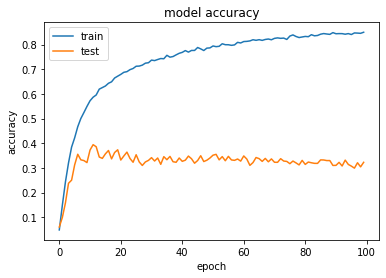

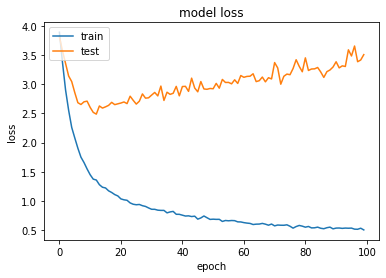

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

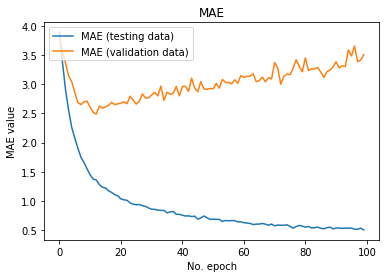

In [32]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

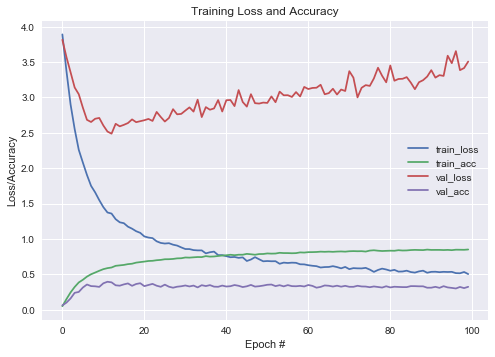

In [33]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochInceptionResNetV2.png')
plt.close()